In [1]:
# Loading the modules used for the analysis

import numpy as np     # To be able to store our numbers in numpy formats already
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from numpy import random
import pandas as pd # Pandas should facilitate a cleaner data analysis
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import wasserstein_distance
import itertools
from scipy import stats


plt.rcParams['figure.figsize'] = [12, 7] # Size of the graphs in inches

evenly_spaced_interval = np.linspace(0, 1, 19)

colors = [cm.tab20(x) for x in evenly_spaced_interval]

### Pre-curating the data

The data will be imported as a list of dictionaries. We also do some pre-processing to get rid of structures where the functional group detection had failed as well as those for which DFT polarizability is not available

In [2]:
import pickle    # The data was saved as a pickle file to make reading and transferring easier
data = []
with open('pickled_data_rev2.txt', 'rb') as file:
        try:
                while True: # Here go all the operations, element by element
                        currdata = pickle.load(file)
                        if "-c1-" in str(currdata[0][1]): # We are NOT interested in conformers, we only load the first conformer for every data here
                                data.append(currdata)
        except EOFError: # Finished with the reading
            pass

In [3]:
# Creating a list of dictionaries that can be searched for various properties
# The only goal is to make the file more readable
                    
alldata = []

for entry in data:
    alldata.append( { 'molid': entry[0][0], 'confid': entry[0][1] , 'atypes': entry[0][2], 
            'hlgap': entry[0][3][0], 'mbd_alpha': entry[0][4][0], 'size': entry[0][5], 
            'dft_alpha': entry[0][6], 'groups': entry[0][7] } )
    
# An example to filter the dataset to all molecules where no functional groups are detected at all

#list(filter(lambda nogroup: nogroup['groups'] == ['not found'], alldata))

In [4]:
# Removing all elements where zero functional groups have been detected

nogroups = list(filter(lambda nogroup: nogroup['groups'] == ['not found'], alldata))

alldata_withgroups = [item for item in alldata if item not in nogroups]

del nogroups # freeing up memory
alldata = alldata_withgroups
del alldata_withgroups

In [5]:
# Adding a few more numbers to the dictionaries

ii=0
for entry in alldata:
    alphas, atoms, sizes = entry["dft_alpha"], entry["atypes"], entry["size"]
    alldata[ii].update( { 'dft_alpha_avg' : (alphas[0]+alphas[1]+alphas[2])/3, 
                      "nelectrons" : np.float64( np.sum( atoms)), "maxsize" : np.float64(sizes[0])} )
    ii+=1

In [6]:
# Removing cases where the DFT calculation had failed

nopol = list(filter(lambda failed_pol: failed_pol['dft_alpha_avg'] < -90, alldata))

alldata_withpol = [item for item in alldata if item not in nopol]

del nopol # freeing up memory
alldata = alldata_withpol
del alldata_withpol

### Loading the data is done

The points are stored in alldata. An example data point is

In [37]:
for key, value in alldata[100].items():
    print(key, ' : ', value)

molid  :  168
confid  :  Geom-m168-i2-c1-opt
atypes  :  [6 6 6 6 8 1 1 1 1 1 1]
hlgap  :  8.036732
mbd_alpha  :  63.485137
size  :  [5.588716978592045, 1.537705, 0.9684630000000001, 3.104132]
dft_alpha  :  [47.31031, 50.0454, 54.54521, 7.58871, -6.22808, -10.2374]
groups  :  ['secondary alcohol', 'alkyne']
dft_alpha_avg  :  50.63363999999999
nelectrons  :  38.0
maxsize  :  5.588716978592045


## Filters based on functional groups

As described in the manuscript, we don't use the full dataset, but only those having some selected functional groups. This selection also needs to be done

In [8]:
# Statistical description of the functional groups present

fcn_groups = open('unique_groups','r')
listgroups = []

# each line is an unique functional group present in the dataset somewhere
for line in fcn_groups:
    listgroups.append(line.strip()) 

group_statistics = [] # Will contain the number of each functional groups

for group in listgroups:
    group_statistics.append({"group": group, "number": len(list(filter(lambda data: group in data['groups'], alldata)))} )


#print("Listing the number of entries corresponding to each functional groups")

#for group in group_statistics:
#    for key, value in group.items():
#        print(key, ' : ', value)

In [9]:
# We restrict our analysis to a selected number of functional groups

remove_manually = ["aromatic compound", "carboxylic acid amidine", "heterocyclic compound", "oxime ether"
                  , "primary amine", "secondary amine", "tertiary aliphatic amine (trialkylamine)", "tertiary amine",
                  "1,2-aminoalcohol", "hydrazine derivative", "alkene","alkyne"]

chosen_group_statistics = list(filter(lambda data: (data['number'] > 300.0 and data['group']
                                          not in remove_manually), group_statistics))

# A list of selected functional group, to be used as a mask in later analysis

chosen_groups = []

for elem in chosen_group_statistics:
    chosen_groups.append(elem["group"])

print("Listing the chosen groups")

for group in chosen_group_statistics:
    for key, value in group.items():
        print(key, ' : ', value)


Listing the chosen groups
group  :  aldehyde
number  :  891
group  :  carbonitrile
number  :  904
group  :  dialkyl ether
number  :  2086
group  :  enol ether
number  :  516
group  :  hydrazone
number  :  567
group  :  ketone
number  :  479
group  :  oxime
number  :  392
group  :  primary alcohol
number  :  1164
group  :  primary aliphatic amine (alkylamine)
number  :  2626
group  :  secondary alcohol
number  :  1780
group  :  secondary aliphatic amine (dialkylamine)
number  :  2023


In [10]:
# General function to test the atomic composition
#  carbons and hydrogens an optional argument, if not set then not tested

def is_atomic_composition(dictionary, oxygen, nitrogen, sulfur, chlorine, carbons=False, hydrogens=False):
    atoms = dictionary["atypes"]
    os, ns = np.count_nonzero(atoms == 8), np.count_nonzero(atoms == 7) #oxygens, nitrogens
    ss, cs = np.count_nonzero(atoms == 16), np.count_nonzero(atoms == 17) #sulfurs, chlorines
    carbs, hs = np.count_nonzero(atoms == 6), np.count_nonzero(atoms == 1)
    if (oxygen == os and nitrogen == ns and sulfur == ss and chlorine == cs and 
        (carbons==False or carbons==carbs) and (hydrogens==False or hydrogens==hs)):
        return True
    else:
        return False
    
def is_alkene(dictionary):
    atoms = dictionary["atypes"]
    os, ns = np.count_nonzero(atoms == 8), np.count_nonzero(atoms == 7) #oxygens, nitrogens
    ss, cs = np.count_nonzero(atoms == 16), np.count_nonzero(atoms == 17) #sulfurs, chlorines
    carbs, hs = np.count_nonzero(atoms == 6), np.count_nonzero(atoms == 1)
    if (carbs *2 == hs) and (os == 0) and (ns == 0) and (ss == 0) and (cs == 0):
        return True
    else:
        return False
    
def is_alkyne(dictionary):
    atoms = dictionary["atypes"]
    os, ns = np.count_nonzero(atoms == 8), np.count_nonzero(atoms == 7) #oxygens, nitrogens
    ss, cs = np.count_nonzero(atoms == 16), np.count_nonzero(atoms == 17) #sulfurs, chlorines
    carbs, hs = np.count_nonzero(atoms == 6), np.count_nonzero(atoms == 1)
    if (carbs *2 == hs+2) and (os == 0) and (ns == 0) and (ss == 0) and (cs == 0):
        return True
    else:
        return False

In [11]:
# General function to check whether a single functional group is present in the data
# using def is_atomic_composition(dictionary, oxygen, nitrogen, sulfur, chlorine, carbons=False, hydrogens=False):

def is_single_group(dictionary, grouptype):
    if grouptype == "aldehyde" and is_atomic_composition(dictionary, 1, 0, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True
    
    elif grouptype == "carbonitrile" and is_atomic_composition(dictionary, 0, 1, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True

    elif grouptype == "dialkyl ether" and is_atomic_composition(dictionary, 1, 0, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True            
            
    elif grouptype == "enol ether" and is_atomic_composition(dictionary, 1, 0, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True              

    elif grouptype == "hydrazone" and is_atomic_composition(dictionary, 0, 2, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True          

    elif grouptype == "ketone" and is_atomic_composition(dictionary, 1, 0, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True   

    elif grouptype == "oxime" and is_atomic_composition(dictionary, 1, 1, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True  

    elif grouptype == "primary alcohol" and is_atomic_composition(dictionary, 1, 0, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True  
  
    elif grouptype == "primary amine" and is_atomic_composition(dictionary, 0, 1, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True      
     
    elif grouptype == "secondary alcohol" and is_atomic_composition(dictionary, 1, 0, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True  

    elif grouptype == "secondary amine" and is_atomic_composition(dictionary, 0, 1, 0, 0) and "alkene" not in dictionary["groups"] and "alkyne" not in dictionary["groups"] :
        return True  
    
    elif grouptype == "alkene" and is_alkene(dictionary):
        return True  
        
    elif grouptype == "alkyne" and is_alkyne(dictionary):
        return True  

    else:
        return False

In [12]:
# Restricted datasets for later analysis

###
# Subset of the data containing only restricted groups
groups_restricted = list(filter(lambda elem: any(entry in chosen_groups for entry in elem['groups']) , alldata))

print("Entries only having groups from the list of restricted ones: ", len(groups_restricted))

groups_restricted_statistics = [] # Will contain the number of each functional groups
for group in chosen_groups:
    groups_restricted_statistics.append({"group": group, "number": len(list(filter(lambda data: group in data['groups'], groups_restricted)))} )

###
# Subset of the data containing only a single restricted group
single_groups = list(filter(lambda elem: is_single_group(elem, elem['groups'][0]) , groups_restricted))

print("Entries only having a SINGLE group from the list of restricted ones: ",len(single_groups))

single_group_statistics = [] # Will contain the number of each functional groups
for group in chosen_groups:
    single_group_statistics.append({"group": group, "number": len(list(filter(lambda data: group in data['groups'], single_groups)))} )
  


Entries only having groups from the list of restricted ones:  9604
Entries only having a SINGLE group from the list of restricted ones:  1626


In [13]:
# Restricting dataset based on atomic composition

### Selected compositions:
# C6H12O


# using
# is_atomic_composition(dictionary, oxygen, nitrogen, sulfur, chlorine, carbons=False, hydrogens=False):

compositions = ["C6H12O", "C4H8O2", "C5H9N"]
composition_data = [[], [], [], []]

composition_data[0] = list(filter(lambda data: is_atomic_composition(data,1, 0, 0, 0, 6, 12 ) , groups_restricted))
composition_data[1] = list(filter(lambda data: is_atomic_composition(data,2, 0, 0, 0, 4, 8 ) , groups_restricted))
composition_data[2] = list(filter(lambda data: is_atomic_composition(data,0, 1, 0, 0, 5, 9 ) , groups_restricted))
composition_data[3] = list(filter(lambda data: is_atomic_composition(data,1, 0, 0, 0, 3, 8 ) , groups_restricted))


    
print(len(composition_data[0]))
print(len(composition_data[1]))
print(len(composition_data[2]))
print(len(composition_data[3]))

393
81
62
3




# Data analysis

After having loaded the data, we proceed to do our analysis.

Any analysis that you intend to do can probably be done on the basis of these ones.

0.9139793369023278
MAE:  14.410790554148097
MAPE:  16.547229558942927 %
12789


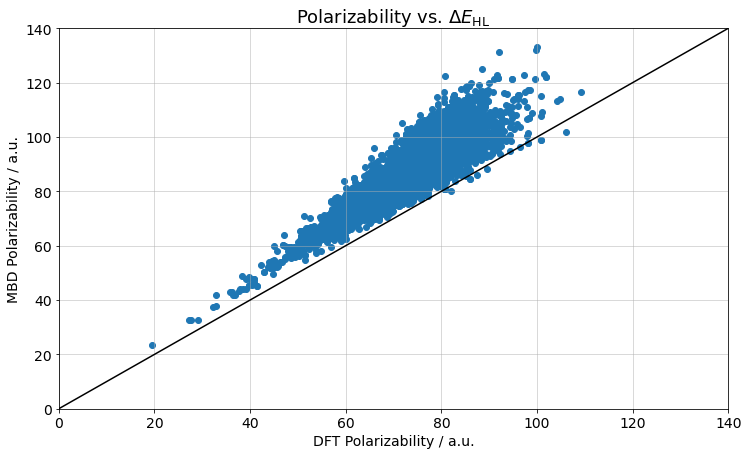

In [43]:
# Accuracy of the MBD@SCS polarizabilities
# DFT vs MBD plot for the whole dataset

dft_alphas = [point["dft_alpha_avg"] for point in alldata]
mbd_alphas = [point["mbd_alpha"] for point in alldata]

flatplot = plt.scatter(dft_alphas, mbd_alphas)

plt.grid(alpha=0.6)

plt.xlabel("DFT Polarizability / a.u.",fontsize=14)
plt.ylabel("MBD Polarizability / a.u.",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,140])
plt.ylim([0,140])
plt.plot([0,140],[0,140], c='k')

#plt.savefig('PAPER_mbd_accuracy.jpg', dpi=600)
plt.title(r"Polarizability vs. $\Delta E_{\mathrm{HL}}$",fontsize=18)

#analyzing the correlation

slope, intercept, r_value, p_value, std_err = stats.linregress(dft_alphas, mbd_alphas)

print(r_value) #R value

mae = np.sum(np.absolute(np.subtract(dft_alphas, mbd_alphas))) / float(len(dft_alphas))
print("MAE: ",mae)

mape = np.sum(np.absolute(np.subtract(dft_alphas, mbd_alphas))/mbd_alphas) / float(len(dft_alphas))
print("MAPE: ",mape*100,"%")

print(len(dft_alphas))

# Clearing up the memory
del dft_alphas
del mbd_alphas

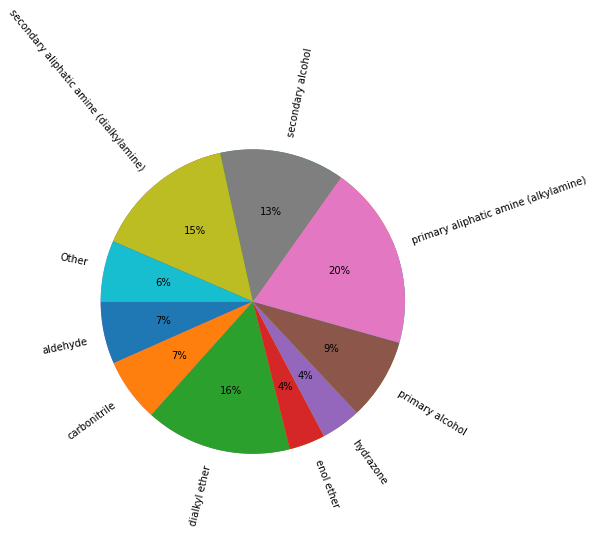

In [15]:
# Functional group distribution on the molecules having the selected groups
# Note: we do not restrict them to having only one of the group

group_names = [point["group"] for point in groups_restricted_statistics]
group_numbers = [point["number"] for point in groups_restricted_statistics]

chosen_group_statistics = list(filter(lambda data: data['number'] > 500.0 , groups_restricted_statistics))

group_names_morethan500 = [point["group"] for point in chosen_group_statistics]
group_numbers_morethan500 = [point["number"] for point in chosen_group_statistics]

other_groups = np.sum(group_numbers) - np.sum(group_numbers_morethan500)

group_names_morethan500.append("Other")
group_numbers_morethan500.append(other_groups)

fig, ax = plt.subplots()
ax.pie(group_numbers_morethan500)

plt.pie(group_numbers_morethan500, labels=group_names_morethan500, autopct='%.0f%%', rotatelabels=True, startangle=180)

#plt.savefig('PAPER_groups_piechart.svg', dpi=1200)

#plt.show()

# Clearing up the memory
del group_names
del group_numbers
del group_names_morethan500
del group_numbers_morethan500

Linear regression: 
R2:  0.06330951218372871
Intercept:  [94.72202717]
Slope:  [[-3.06986502]]
(1626,)


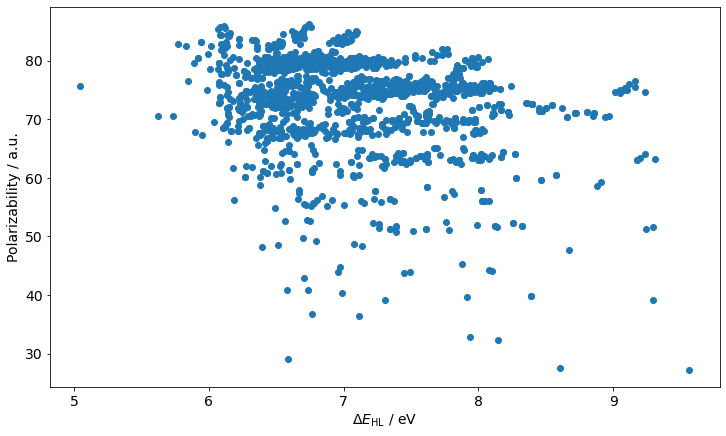

In [40]:
# Creating the HLgap vs alpha plot for the reduced (selected) dataset

dft_polarizabilities =  np.asarray( [point["dft_alpha_avg"] for point in single_groups] )
hlgaps = np.asarray( [point["hlgap"] for point in single_groups] )


selectedplot = plt.scatter(hlgaps,dft_polarizabilities)
plt.xlabel(r"$\Delta E_{\mathrm{HL}}$ / eV",fontsize=14)
plt.ylabel("Polarizability / a.u.",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title(r"Polarizability vs. $\Delta E_{\mathrm{HL}}$",fontsize=18)

reg = LinearRegression().fit(hlgaps.reshape(-1,1),dft_polarizabilities.reshape(-1,1))
print('Linear regression: ')
print("R2: ",reg.score(hlgaps.reshape(-1,1), dft_polarizabilities.reshape(-1,1)))
print("Intercept: ",reg.intercept_)
print("Slope: ",reg.coef_)

print(dft_polarizabilities.shape)

#plt.savefig('PAPER_hlgap_vs_alpha.png', dpi = 600)


### Plotting compositions and groups on the main plot

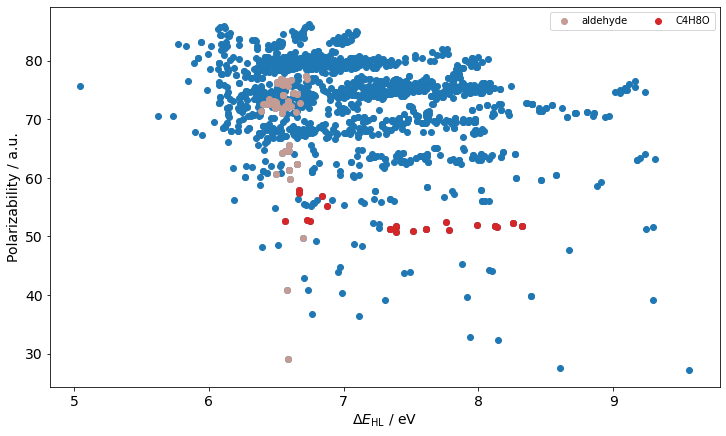

In [34]:
# using def is_atomic_composition(dictionary, oxygen, nitrogen, sulfur, chlorine, carbons=False, hydrogens=False):

#chosen_groups[0] is aldehyde

c4h8o_list = list(filter(lambda elem: is_atomic_composition(elem, 1, 0, 0, 0, 4, 8), single_groups))
c4h8o2_list = list(filter(lambda elem: is_atomic_composition(elem, 2, 0, 0, 0, 4, 8), single_groups))
aldehyde_list = list(filter(lambda elem: chosen_groups[0] in elem["groups"] and "alkene" not in elem["groups"] and "alkyne" not in elem["groups"], single_groups))

dft_polarizabilities_c4h8o =  np.asarray( [point["dft_alpha_avg"] for point in c4h8o_list] )
hlgaps_c4h8o = np.asarray( [point["hlgap"] for point in c4h8o_list] )

dft_polarizabilities_c4h8o2 =  np.asarray( [point["dft_alpha_avg"] for point in c4h8o2_list] )
hlgaps_c4h8o2 = np.asarray( [point["hlgap"] for point in c4h8o2_list] )

dft_polarizabilities_aldehyde =  np.asarray( [point["dft_alpha_avg"] for point in aldehyde_list] )
hlgaps_aldehyde = np.asarray( [point["hlgap"] for point in aldehyde_list] )


list_of_plots=[]
list_of_plots.append(plt.scatter(hlgaps,dft_polarizabilities))
list_of_plots.append(plt.scatter(hlgaps_aldehyde,dft_polarizabilities_aldehyde,color=colors[10],label=chosen_groups[0]))
list_of_plots.append(plt.scatter(hlgaps_c4h8o,dft_polarizabilities_c4h8o,color=colors[6],label="C4H8O"))


plt.xlabel(r"$\Delta E_{\mathrm{HL}}$ / eV",fontsize=14)
plt.ylabel("Polarizability / a.u.",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title(r"Polarizability vs. $\Delta E_{\mathrm{HL}}$",fontsize=18)

plt.legend(loc="upper right",ncol=2)

plt.savefig('PAPER_aldehyde_c4h8o.svg', dpi = 600)

# clear memory
del c4h8o_list
del c4h8o2_list
#for point in aldehyde_list:
#    print(point["groups"])
#print(aldehyde_list)
del aldehyde_list

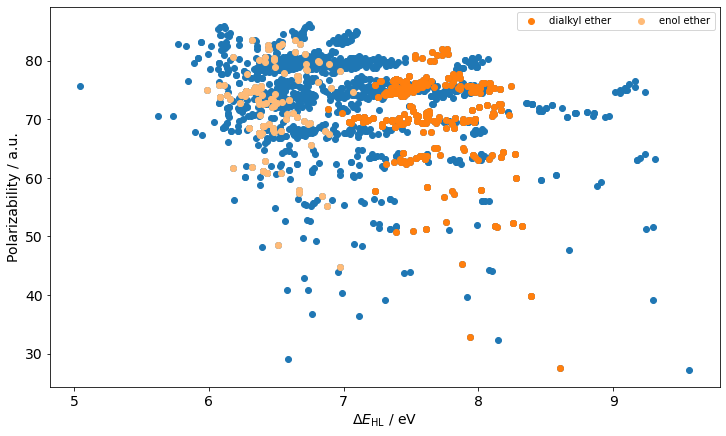

In [35]:
secondgroup_list = list(filter(lambda elem: chosen_groups[2] in elem["groups"], single_groups))
thirdgroup_list = list(filter(lambda elem: chosen_groups[3] in elem["groups"], single_groups))

dft_polarizabilities_second =  np.asarray( [point["dft_alpha_avg"] for point in secondgroup_list] )
hlgaps_second = np.asarray( [point["hlgap"] for point in secondgroup_list] )

dft_polarizabilities_third =  np.asarray( [point["dft_alpha_avg"] for point in thirdgroup_list] )
hlgaps_third = np.asarray( [point["hlgap"] for point in thirdgroup_list] )
        
list_of_plots = []

list_of_plots.append(plt.scatter(hlgaps,dft_polarizabilities))
list_of_plots.append(plt.scatter(hlgaps_second,dft_polarizabilities_second,color=colors[2],label=chosen_groups[2]))
list_of_plots.append(plt.scatter(hlgaps_third,dft_polarizabilities_third,color=colors[3],label=chosen_groups[3]))


plt.xlabel(r"$\Delta E_{\mathrm{HL}}$ / eV",fontsize=14)
plt.ylabel("Polarizability / a.u.",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title(r"Polarizability vs. $\Delta E_{\mathrm{HL}}$",fontsize=18)

plt.legend(loc="upper right",ncol=2)

plt.savefig('PAPER_ethers_separation.svg', dpi = 600)



## Predictor using the size

MAE:  2.636258933284793
MAPE:  3.664113835247509 %


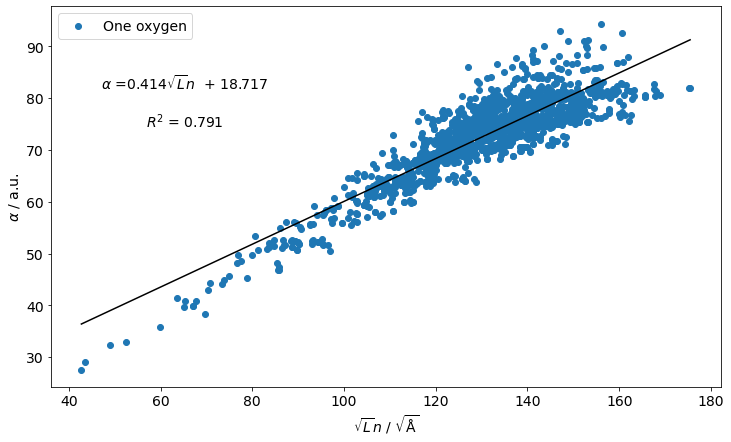

MAE:  2.4299112968769885
MAPE:  3.2344104680448975 %


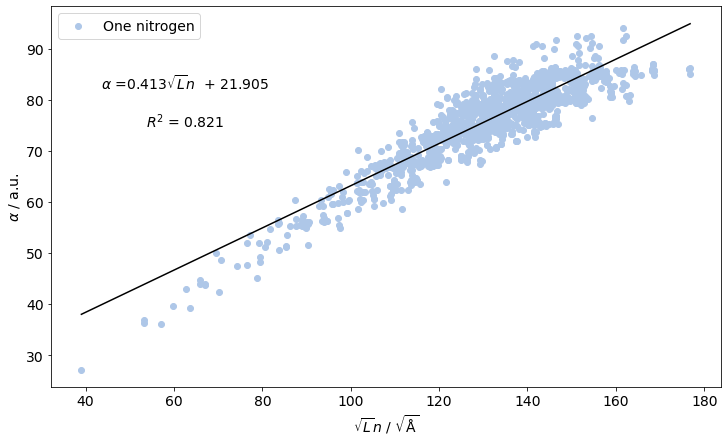

MAE:  1.9630974454820296
MAPE:  2.999257946312188 %


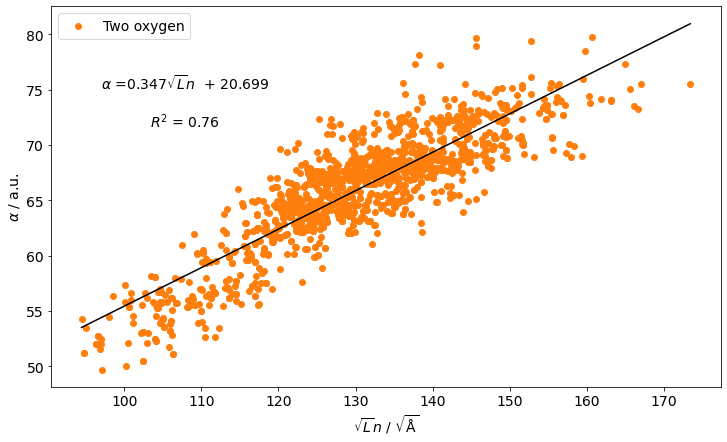

MAE:  2.8541636148067635
MAPE:  3.7906118570550413 %


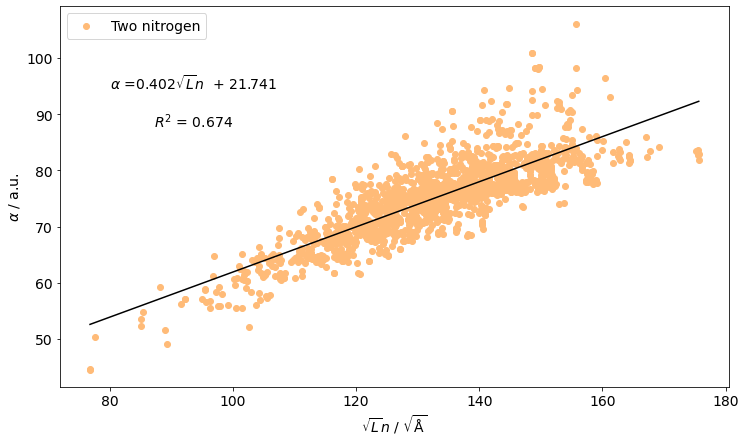

MAE:  2.3943581556912235
MAPE:  3.453403758938753 %


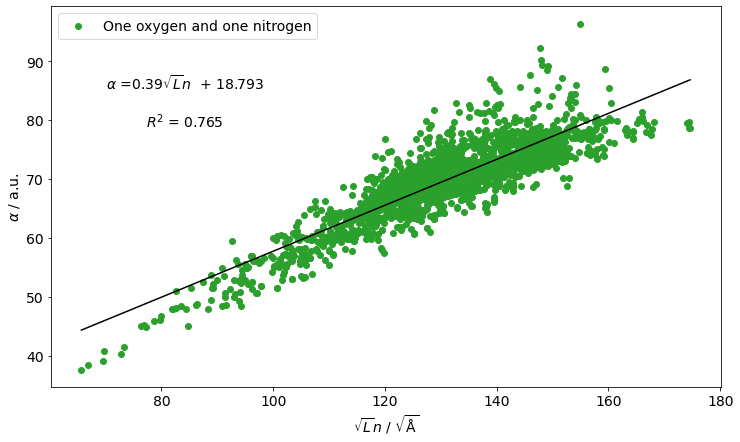

MAE:  3.651127727736912
MAPE:  4.547469433365696 %


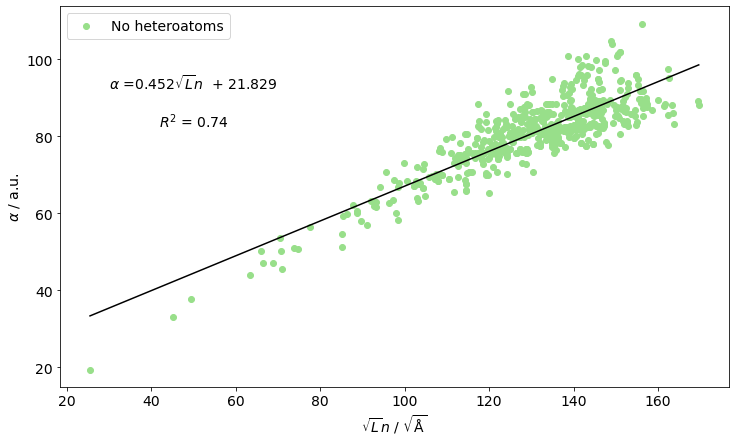

In [19]:
# Now we set out to make a sorting based on atomic composition instead of functional groups

# We use all data here

element_list = [[],[],[],[],[], []] #1 O, 1 N, 2 O, 2 N, 1N+1O, no hetero

element_list[0] = list(filter(lambda elem: is_atomic_composition(elem, 1, 0, 0, 0), alldata))
element_list[1] = list(filter(lambda elem: is_atomic_composition(elem, 0, 1, 0, 0), alldata))
element_list[2] = list(filter(lambda elem: is_atomic_composition(elem, 2, 0, 0, 0), alldata))
element_list[3] = list(filter(lambda elem: is_atomic_composition(elem, 0, 2, 0, 0), alldata))
element_list[4] = list(filter(lambda elem: is_atomic_composition(elem, 1, 1, 0, 0), alldata))
element_list[5] = list(filter(lambda elem: is_atomic_composition(elem, 0, 0, 0, 0), alldata))

        
atomtypes = ['One oxygen','One nitrogen','Two oxygen','Two nitrogen','One oxygen and one nitrogen',"No heteroatoms"]

hlgaps_atypes, alphas_atypes = [], []
sizes_atypes, nelec_atypes = [], []

for ii in range(len(element_list)):
    alphas_atypes.append(  np.asarray( [point["dft_alpha_avg"] for point in element_list[ii]] ) )
    hlgaps_atypes.append(  np.asarray( [point["hlgap"] for point in element_list[ii]] ) )
    sizes_atypes.append(  np.asarray( [point["maxsize"] for point in element_list[ii]] ) )
    nelec_atypes.append(  np.asarray( [point["nelectrons"] for point in element_list[ii]] ) )
                       

for ii in range(len(element_list)):
    pred = nelec_atypes[ii]* np.sqrt( sizes_atypes[ii] )  
    reg = LinearRegression().fit(pred.reshape(-1,1),np.asarray( alphas_atypes[ii] ).reshape(-1,1))
        
    plt.scatter(pred,alphas_atypes[ii],color=colors[ii],label=atomtypes[ii])
    
    plt.legend(loc="upper left",fontsize=14)
    plt.xlabel(r"$\sqrt{L} n$ / $\sqrt{\mathrm{\AA}}$",fontsize=14)
    plt.ylabel(r"$\alpha$ / a.u.",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.title(r"Product predictor performance for polarizability",fontsize=18)
    
    string=r"$\alpha$ ="+str( round(reg.coef_[0][0],3)  )+"$\sqrt{L} n$ "+" + "+str( round(reg.intercept_[0],3) )
    
    plt.text(0.2,0.8, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)

    string="$R^2$ = "+str( round(reg.score(pred.reshape(-1,1), np.asarray( alphas_atypes[ii] ).reshape(-1,1)),3)) 
    plt.text(0.2,0.7, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)

    x_fit = np.linspace(np.min(pred), np.max(pred), 501 )
    
    plt.plot(x_fit,x_fit*reg.coef_[0]+reg.intercept_,c='k')
    
    mae = np.sum(np.absolute(np.subtract(alphas_atypes[ii], pred*reg.coef_[0]+reg.intercept_))) / float(len(alphas_atypes[ii]))
    print("MAE: ",mae)

    mape = np.sum(np.absolute(np.subtract(alphas_atypes[ii], pred*reg.coef_[0]+reg.intercept_))/(pred*reg.coef_[0]+reg.intercept_)) / float(len(alphas_atypes[ii]))
    print("MAPE: ",mape*100,"%")
    
    
    plotname_string="PAPER_"+atomtypes[ii]+"_predfit.png"
#    plt.savefig(plotname_string)
    
#    for jj in range(10):
#        print(alphas_atypes[ii][jj],pred[jj],reg.predict(pred.reshape(-1,1))[jj])
    
    plt.show()
    


## Additive model for polarizability

In [20]:
def additive_model(atomic_composition):
    total_pol = 2.1460 # We start from the value of the intercept
    for atom in atomic_composition:
        if atom==6:
            total_pol+=10.19
        elif atom==1:
            total_pol+=1.174
        elif atom==7:
            total_pol+=6.951
        elif atom==8:
            total_pol+=3.853
    return total_pol

def additive_model_to_fit(atomic_composition,coefficients):
    #coefficients = [2.1460, 10.19, 1.174, 6.951, 3.853]
    total_pol = coefficients[0] # We start from the value of the intercept
    for atom in atomic_composition:
        if atom==6:
            total_pol+=coefficients[1]
        elif atom==1:
            total_pol+=coefficients[2]
        elif atom==7:
            total_pol+=coefficients[3]
        elif atom==8:
            total_pol+=coefficients[4]
        elif atom==17:
            total_pol+=coefficients[5]
        elif atom==16:
            total_pol+=coefficients[6]
    return total_pol


Error statistics for the plot ABOVE:
MAE:  4.56597353780072
MAPE:  6.372711225333377 %


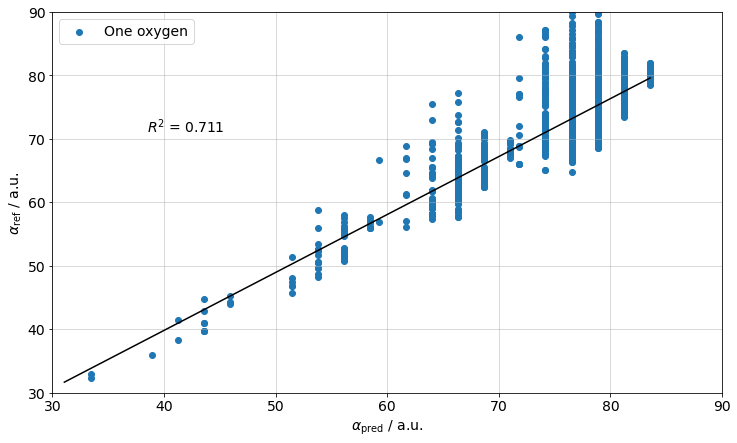

Error statistics for the plot ABOVE:
MAE:  4.786642603657477
MAPE:  6.416418505745391 %


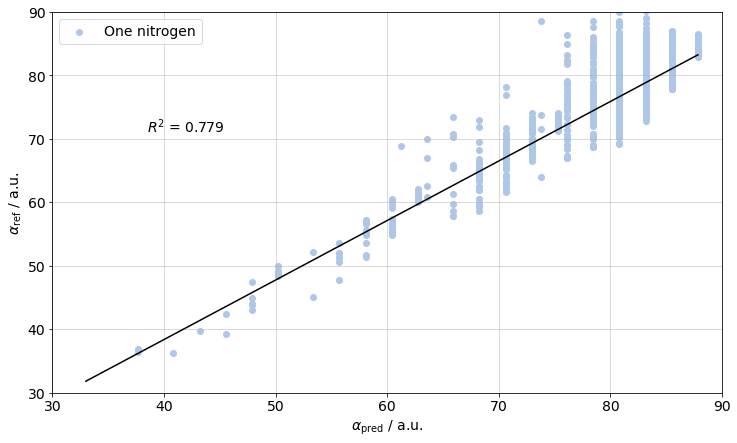

Error statistics for the plot ABOVE:
MAE:  3.8743866802076505
MAPE:  5.990421440337704 %


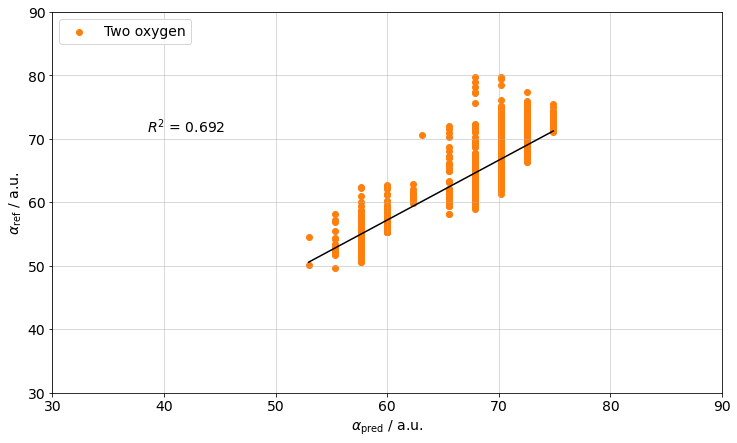

Error statistics for the plot ABOVE:
MAE:  4.369170055112151
MAPE:  5.860239215682333 %


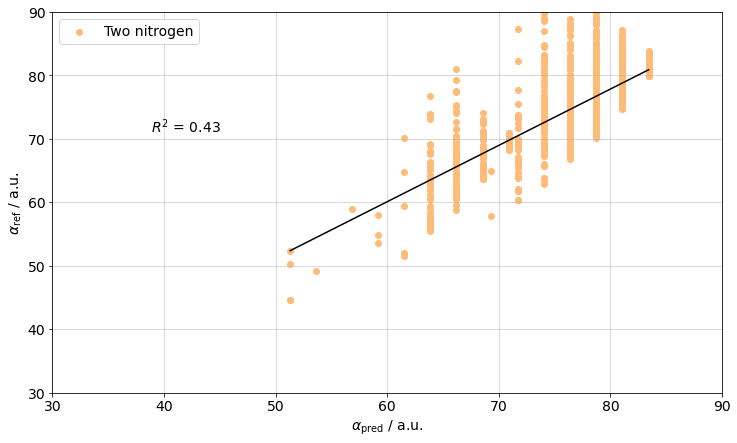

Error statistics for the plot ABOVE:
MAE:  4.192977318397859
MAPE:  6.108528362018414 %


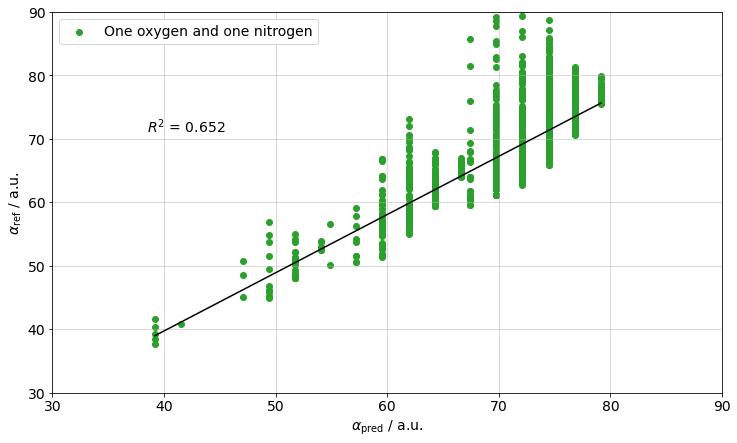

Error statistics for the plot ABOVE:
MAE:  4.738611280120504
MAPE:  5.845832866048188 %


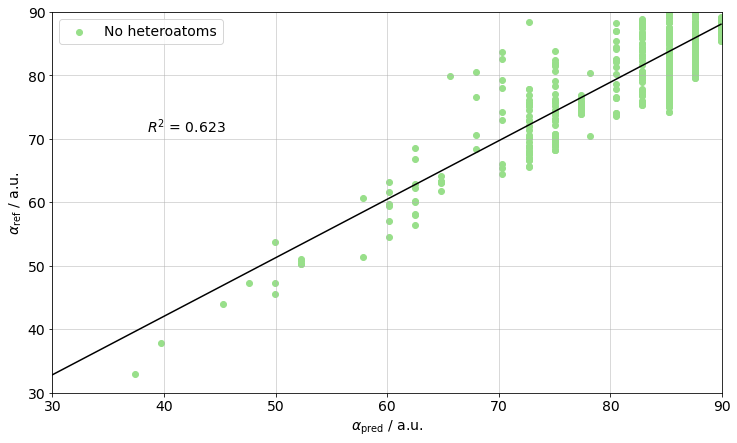

overall r2:  0.6226349186994439
overall mae:  4.738611280120504
overall mape:  5.845832866048188


In [21]:
atomic_compositions = [] #1 O, 1 N, 2 O, 2 N, 1N+1O, no hetero

for ii in range(len(element_list)):
    atomic_compositions.append( [point["atypes"] for point in element_list[ii]]  )


for ii in range(len(element_list)):
    pred=[]
    overall_pred, overall_alphas = [], [] # To get R2 and MAE for the full dataset
    for jj in range(len(element_list[ii])):
        pred.append(additive_model(atomic_compositions[ii][jj]))
        overall_pred.append(additive_model(atomic_compositions[ii][jj]))
        overall_alphas.append(alphas_atypes[ii][jj])
        
    pred = np.asarray(pred)
    reg = LinearRegression().fit(pred.reshape(-1,1),np.asarray( alphas_atypes[ii] ).reshape(-1,1))

        
    plt.scatter(pred,alphas_atypes[ii],color=colors[ii],label=atomtypes[ii])
    
    plt.legend(loc="upper left",fontsize=14)
    plt.xlabel(r"$\alpha_\mathrm{pred}$ / a.u.",fontsize=14)
    plt.ylabel(r"$\alpha_\mathrm{ref}$ / a.u.",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
#    plt.title(r"Atomic addition performance for polarizability",fontsize=18)
    
    #string=r"$\alpha$ ="+str( round(reg.coef_[0][0],3)  )+"$\sqrt{L} n$ "+" + "+str( round(reg.intercept_[0],3) )
    
    #plt.text(0.2,0.8, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)

    string="$R^2$ = "+str( round(reg.score(pred.reshape(-1,1), np.asarray( alphas_atypes[ii] ).reshape(-1,1)),3)) 
    plt.text(0.2,0.7, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)

    x_fit = np.linspace(np.min(pred), np.max(pred), 501 )
    plt.grid(alpha=0.6)
    plt.xlim([30,90])
    plt.ylim([30,90])
    plt.plot(x_fit,x_fit*reg.coef_[0]+reg.intercept_,c='k')
    
    
    plotname_string="PAPER_"+atomtypes[ii]+"_predfit_additive.png"
#    plt.savefig(plotname_string, dpi=600)
    
    print("Error statistics for the plot ABOVE:")
    
    print("MAE: ", np.sum( np.abs( pred - alphas_atypes[ii] )  )/np.size(alphas_atypes[ii]) )

    print("MAPE: ", 100.0*np.sum( np.abs( pred - alphas_atypes[ii] )/alphas_atypes[ii]   )/np.size(alphas_atypes[ii]),"%")
    
    plt.show()
           
overall_pred = np.asarray( overall_pred )
overall_alphas = np.asarray( overall_alphas )


overall_r2 = reg.score(  overall_pred.reshape(-1,1), overall_alphas.reshape(-1,1) )

overall_mae =  np.sum( np.abs( overall_pred - overall_alphas )  )/np.size(overall_alphas)

overall_mape = 100.0*np.sum( np.abs( overall_pred - overall_alphas )/overall_alphas   )/np.size(overall_alphas)

print("overall r2: ", overall_r2)
print("overall mae: ", overall_mae)
print("overall mape: ", overall_mape)


Linear regression: 
R2:  0.7168777935209358
Intercept:  1.70654645041445
Slope:  [10.12962552  0.87239805  7.87538279  3.9990118  12.74315401 19.13428269]
12789


Text(0.2, 0.7, '$R^2$ = 0.717')

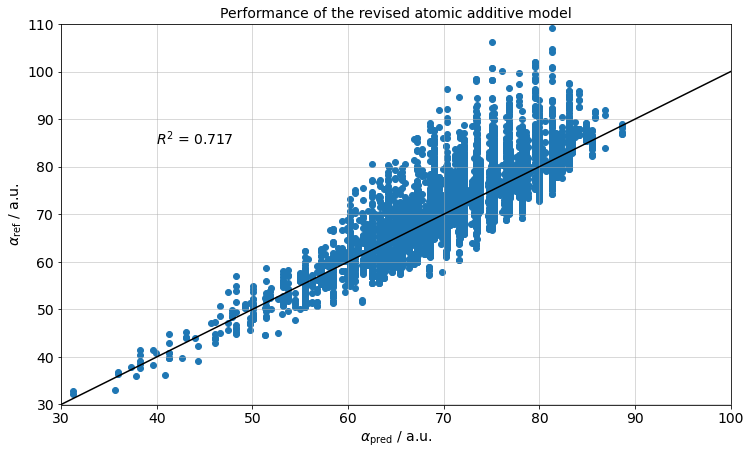

In [22]:
# Now we do  the linear fit, for all polarizabilities by atom types

target_dft_alphas = [point["dft_alpha_avg"] for point in alldata]

elements = [point["atypes"] for point in alldata]

elements_counted=[]

for datapoint in elements:
    carbons, hydrogens, nitrogens, oxygens, chlorines, sulfurs = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    for countme in datapoint:
        if countme == 6:
            carbons += 1.0
        elif countme == 1:
            hydrogens += 1.0
        elif countme == 7:
            nitrogens += 1.0
        elif countme == 8:
            oxygens += 1.0
        elif countme == 17:
            chlorines += 1.0
        elif countme == 16:
            sulfurs += 1.0
    elements_counted.append( [carbons, hydrogens, nitrogens, oxygens, chlorines, sulfurs] )

# Multivariate nonlinear regression
reg = LinearRegression().fit(elements_counted,target_dft_alphas)
print('Linear regression: ')
print("R2: ",reg.score(elements_counted, target_dft_alphas))
print("Intercept: ",reg.intercept_)
print("Slope: ",reg.coef_)
print(len(target_dft_alphas))

plt.scatter(reg.predict(elements_counted), target_dft_alphas)
plt.xlabel(r"$\alpha_\mathrm{pred}$ / a.u.",fontsize=14)
plt.ylabel(r"$\alpha_\mathrm{ref}$ / a.u.",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

x_fit = np.linspace(np.min(target_dft_alphas), np.max(target_dft_alphas), 501 )
plt.grid(alpha=0.6)
plt.xlim([30,100])
plt.ylim([30,110])
plt.plot(x_fit,x_fit,'k')

plt.title("Performance of the revised atomic additive model",fontsize=14)

string="$R^2$ = "+str( round( reg.score(elements_counted, target_dft_alphas) , 3))
plt.text(0.2,0.7, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)

#plt.show()

#plt.savefig("revised_additive.png", dpi=600)

Error statistics for the plot ABOVE:
MAE:  2.939581938402587
MAPE:  3.9865953885954943 %


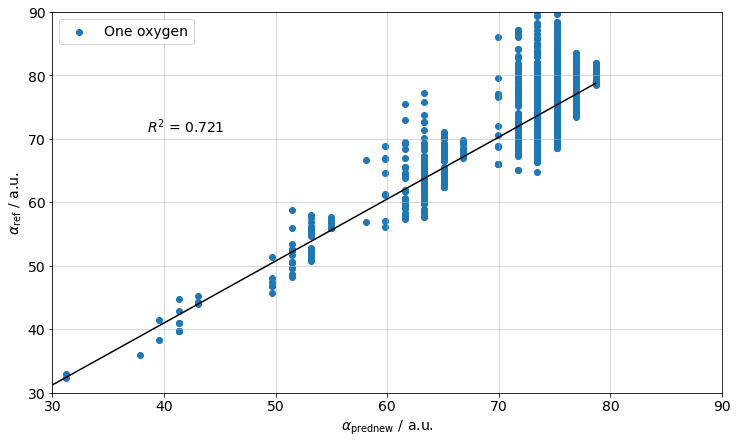

Error statistics for the plot ABOVE:
MAE:  2.887850074319989
MAPE:  3.8448975266670513 %


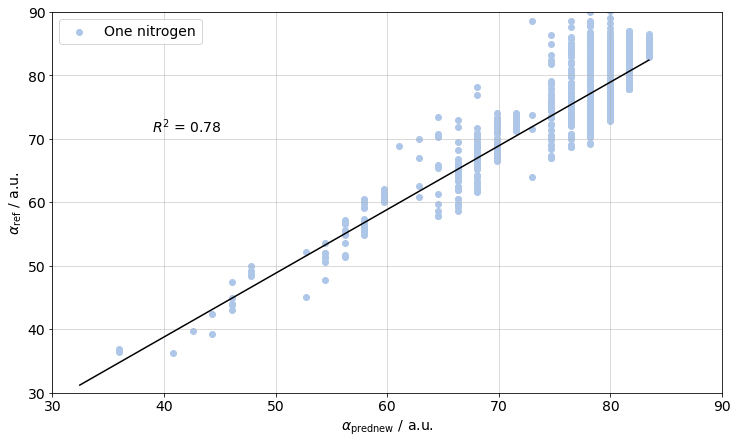

Error statistics for the plot ABOVE:
MAE:  2.2329829047305245
MAPE:  3.395464657062476 %


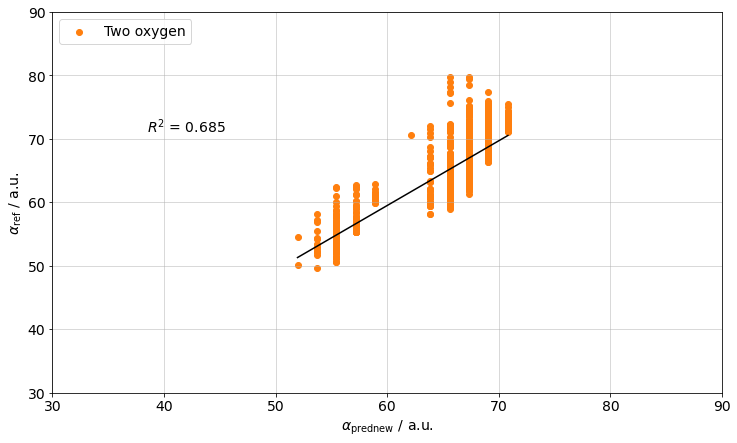

Error statistics for the plot ABOVE:
MAE:  3.689666734130142
MAPE:  4.8827223528462795 %


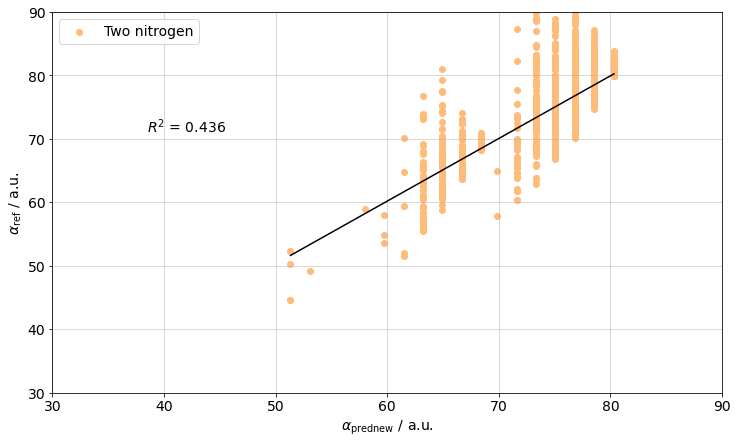

Error statistics for the plot ABOVE:
MAE:  2.937087878150879
MAPE:  4.231863636647332 %


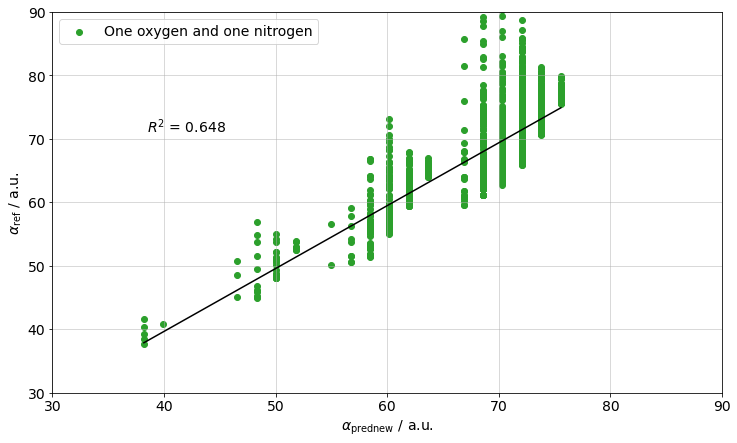

Error statistics for the plot ABOVE:
MAE:  4.340960563694088
MAPE:  5.1485570921817265 %


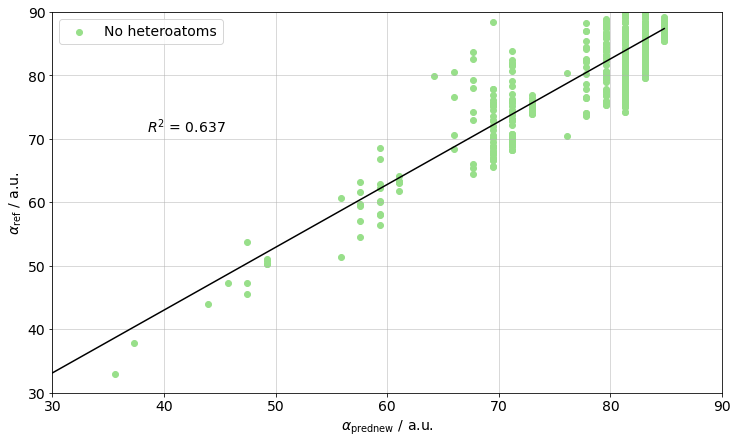

overall r2:  0.6374645725070293
overall mae:  4.340960563694088
overall mape:  5.1485570921817265


In [23]:
coefficients = [1.7065464504145638, 10.12962552,  0.87239805,  7.87538279,  3.9990118,  12.74315401, 19.13428269]

atomic_compositions = [] #1 O, 1 N, 2 O, 2 N, 1N+1O, no hetero

for ii in range(len(element_list)):
    atomic_compositions.append( [point["atypes"] for point in element_list[ii]]  )


for ii in range(len(element_list)):
    pred=[]
    overall_pred, overall_alphas = [], [] # To get R2 and MAE for the full dataset
    for jj in range(len(element_list[ii])):
        pred.append(additive_model_to_fit(atomic_compositions[ii][jj], coefficients))
        overall_pred.append(additive_model_to_fit(atomic_compositions[ii][jj], coefficients))
        overall_alphas.append(alphas_atypes[ii][jj])
        
    pred = np.asarray(pred)
    reg = LinearRegression().fit(pred.reshape(-1,1),np.asarray( alphas_atypes[ii] ).reshape(-1,1))

        
    plt.scatter(pred,alphas_atypes[ii],color=colors[ii],label=atomtypes[ii])
    
    plt.legend(loc="upper left",fontsize=14)
    plt.xlabel(r"$\alpha_\mathrm{prednew}$ / a.u.",fontsize=14)
    plt.ylabel(r"$\alpha_\mathrm{ref}$ / a.u.",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
#    plt.title(r"Atomic addition performance for polarizability",fontsize=18)
    
    #string=r"$\alpha$ ="+str( round(reg.coef_[0][0],3)  )+"$\sqrt{L} n$ "+" + "+str( round(reg.intercept_[0],3) )
    
    #plt.text(0.2,0.8, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)

    string="$R^2$ = "+str( round(reg.score(pred.reshape(-1,1), np.asarray( alphas_atypes[ii] ).reshape(-1,1)),3)) 
    plt.text(0.2,0.7, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)

    x_fit = np.linspace(np.min(pred), np.max(pred), 501 )
    plt.grid(alpha=0.6)
    plt.xlim([30,90])
    plt.ylim([30,90])
    plt.plot(x_fit,x_fit*reg.coef_[0]+reg.intercept_,c='k')
    
    
    plotname_string="PAPER_"+atomtypes[ii]+"_predfit_additive.png"
#    plt.savefig(plotname_string, dpi=600)
    
    print("Error statistics for the plot ABOVE:")
    
    print("MAE: ", np.sum( np.abs( pred - alphas_atypes[ii] )  )/np.size(alphas_atypes[ii]) )

    print("MAPE: ", 100.0*np.sum( np.abs( pred - alphas_atypes[ii] )/alphas_atypes[ii]   )/np.size(alphas_atypes[ii]),"%")
    
    plt.show()
           
overall_pred = np.asarray( overall_pred )
overall_alphas = np.asarray( overall_alphas )


overall_r2 = reg.score(  overall_pred.reshape(-1,1), overall_alphas.reshape(-1,1) )

overall_mae =  np.sum( np.abs( overall_pred - overall_alphas )  )/np.size(overall_alphas)

overall_mape = 100.0*np.sum( np.abs( overall_pred - overall_alphas )/overall_alphas   )/np.size(overall_alphas)

print("overall r2: ", overall_r2)
print("overall mae: ", overall_mae)
print("overall mape: ", overall_mape)


## Grouping of the dataset

In [24]:
# Creating a list of lists, where each list contains items having a single functional groups
# Data in single_groups, list of groups in chosen_groups
data_by_groups = []

for functional_group in chosen_groups:
    data_by_groups.append( list(filter(lambda elem: functional_group in elem["groups"], single_groups)) )
    
# Individual element of data_by_groups now contains data points for the corresponding chosen_group

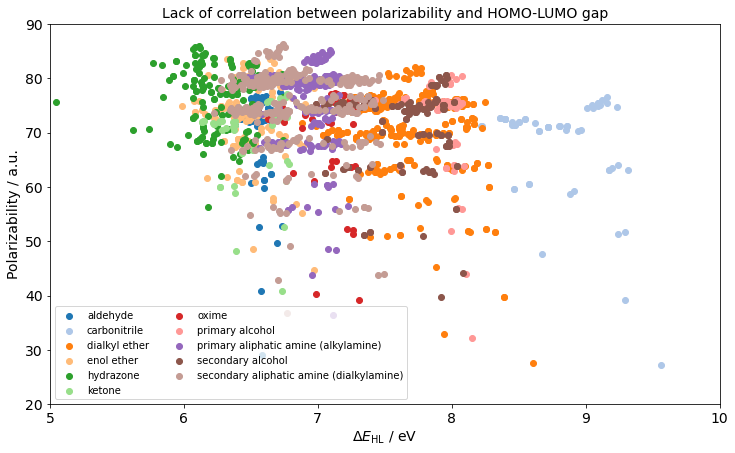

In [25]:
# Making the full plot of the distributin of the groups

hlgaps_fcngroup, alphas_fcngroup = [[] for i in range(len(data_by_groups))], [[] for i in range(len(data_by_groups))]

for ii in range(len(data_by_groups)):
    alphas_fcngroup[ii] = [point["dft_alpha_avg"] for point in data_by_groups[ii]]
    hlgaps_fcngroup[ii] = [point["hlgap"] for point in data_by_groups[ii]]

list_of_plots = []
        
    
for ii in range(len(data_by_groups)):
    list_of_plots.append(plt.scatter(hlgaps_fcngroup[ii],alphas_fcngroup[ii],color=colors[ii],label=chosen_groups[ii]))

plt.xlabel(r"$\Delta E_{\mathrm{HL}}$ / eV",fontsize=14)
plt.ylabel("Polarizability / a.u.",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([5,10])
plt.ylim([20,90])
plt.title("Lack of correlation between polarizability and HOMO-LUMO gap",fontsize=14)

plt.legend(loc="lower left",ncol=2)

plt.savefig('flat_hlgap_vs_alpha_groups.svg',dpi=1200)

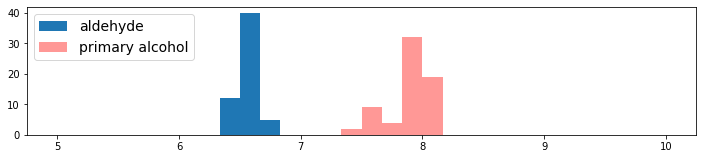

In [26]:
# Aldehyde is [0]
fig, ax = plt.subplots()
plt.hist(hlgaps_fcngroup[0], 30, range=[5,10], color=colors[0], label=chosen_groups[0])
ax.set_aspect(0.025)

plt.hist(hlgaps_fcngroup[7], 30, range=[5,10], color=colors[7], label=chosen_groups[7])
plt.legend(loc="upper left",fontsize=14)
plt.savefig('putontop.svg',dpi=1200)

#for ii in range(len(data_by_groups)):
#    list_of_plots.append(plt.scatter(hlgaps_fcngroup[ii],alphas_fcngroup[ii],color=colors[ii],label=chosen_groups[ii]))

#plt.xlabel(r"$\Delta E_{\mathrm{HL}}$ / eV",fontsize=14)
#plt.ylabel("Polarizability / a.u.",fontsize=14)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.title("Lack of correlation between polarizability and HOMO-LUMO gap",fontsize=14)

#plt.legend(loc="upper right",ncol=2)

#plt.savefig('flat_hlgap_vs_alpha_groups.png',dpi=1200)

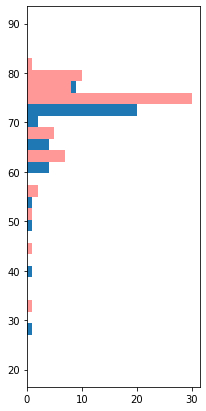

In [27]:
# Aldehyde is [0]
fig, ax = plt.subplots()

plt.hist(alphas_fcngroup[0], 30, range=[20,90], color=colors[0], orientation='horizontal')

ax.set_aspect(0.9)

plt.hist(alphas_fcngroup[7], 30, range=[20,90], color=colors[7], orientation='horizontal')
plt.savefig('putonsize.svg',dpi=1200)



aldehyde_carbonitrile_hlgaps.png


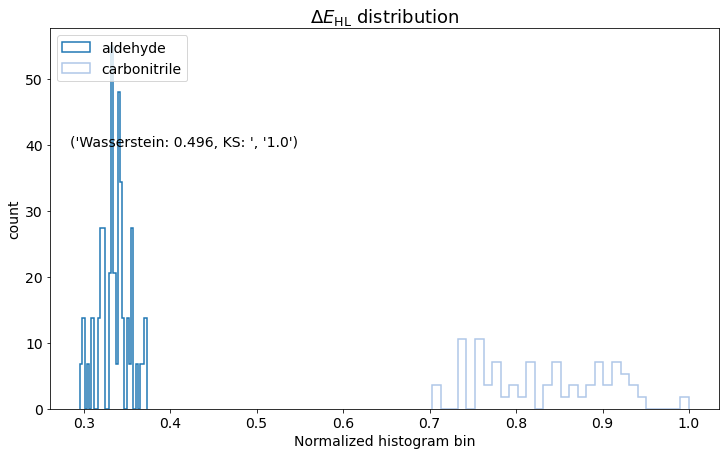

aldehyde_dialkyl ether_hlgaps.png


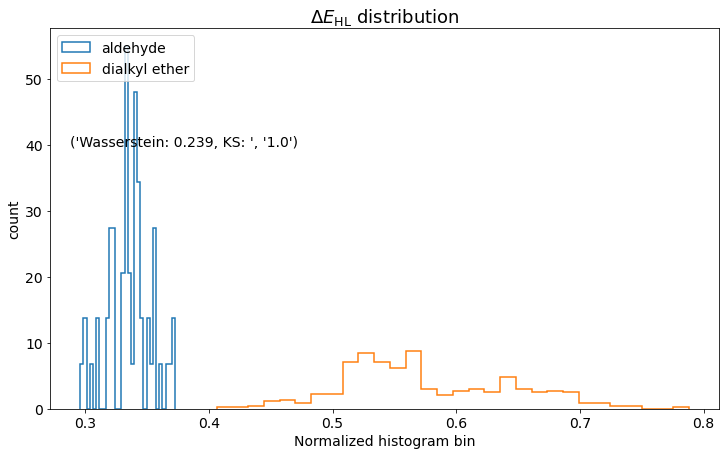

aldehyde_enol ether_hlgaps.png


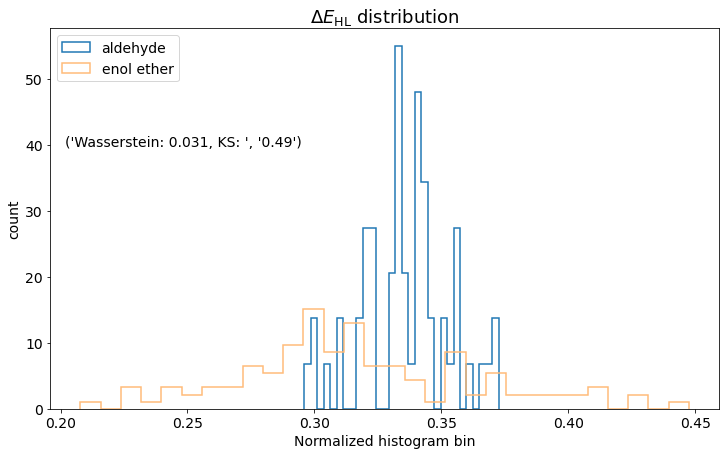

aldehyde_hydrazone_hlgaps.png


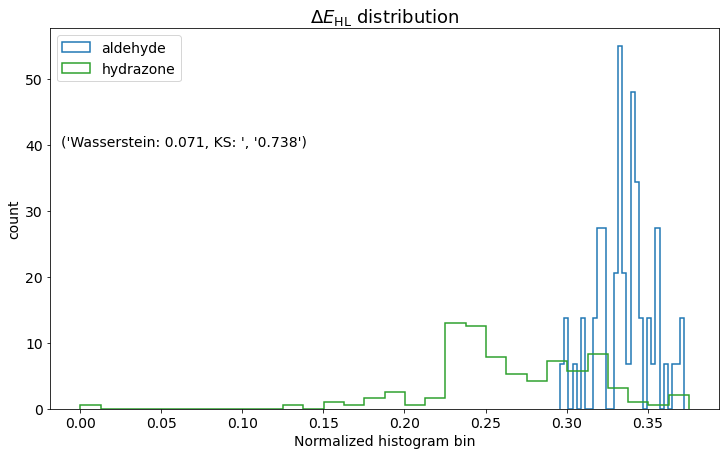

aldehyde_ketone_hlgaps.png


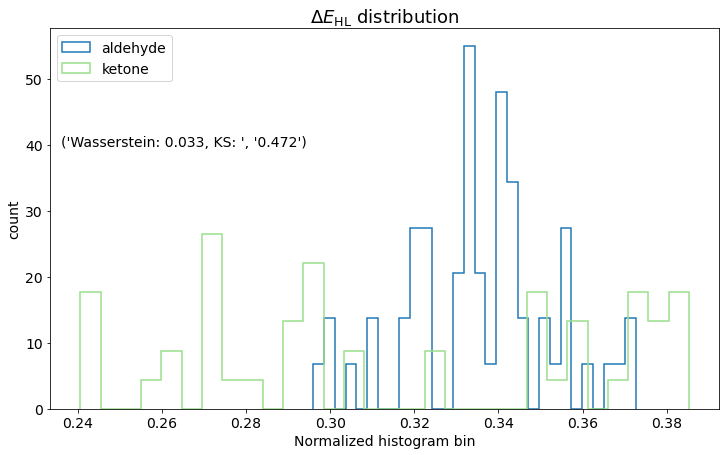

aldehyde_oxime_hlgaps.png


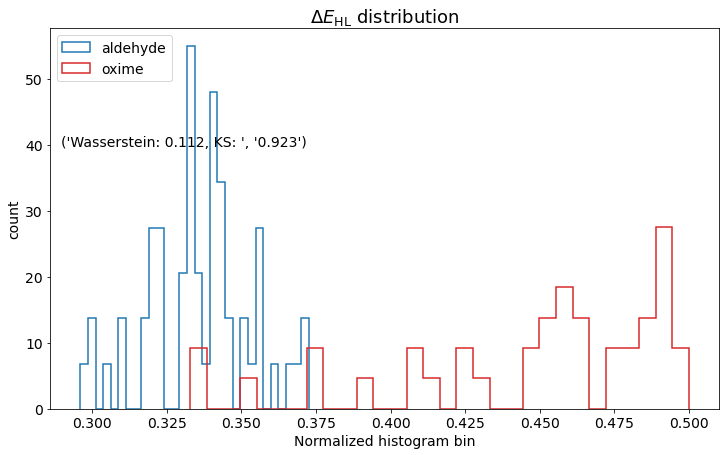

aldehyde_primary alcohol_hlgaps.png


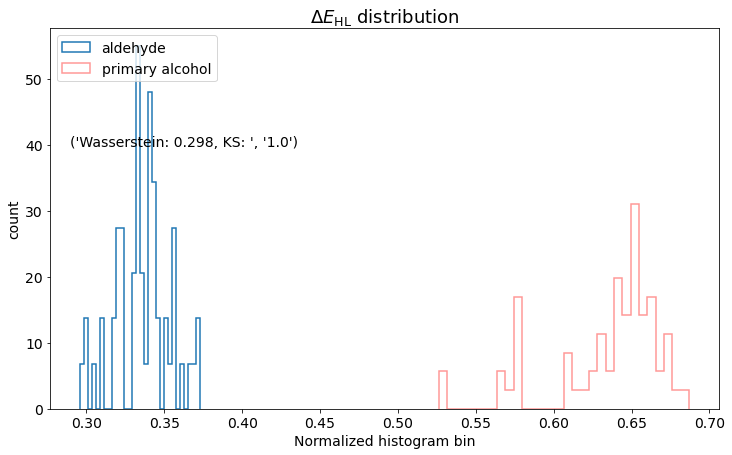

aldehyde_primary aliphatic amine (alkylamine)_hlgaps.png


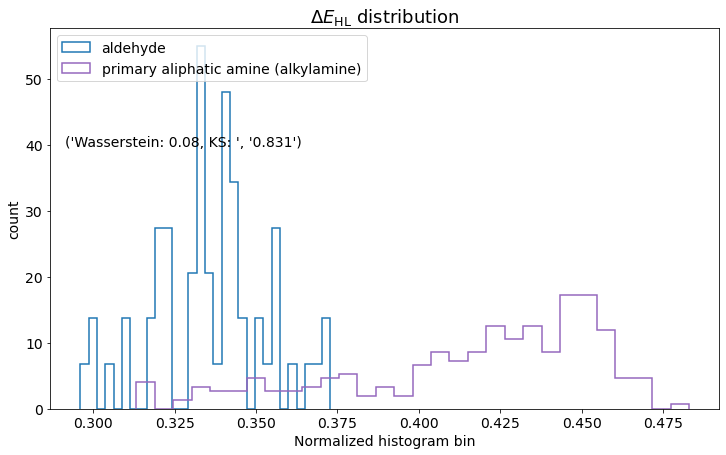

aldehyde_secondary alcohol_hlgaps.png


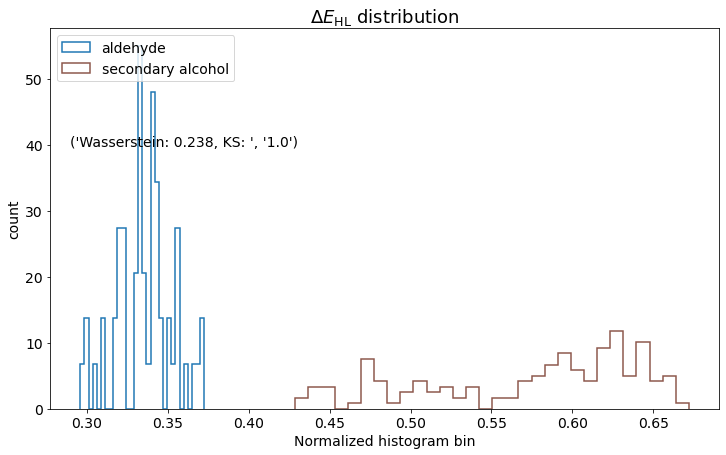

aldehyde_secondary aliphatic amine (dialkylamine)_hlgaps.png


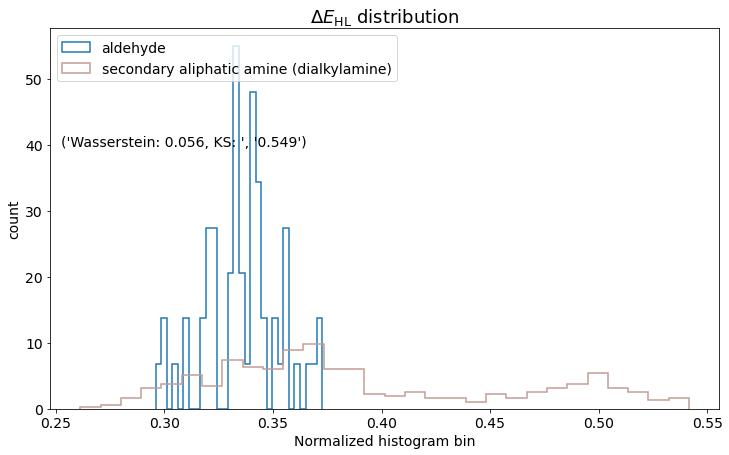

carbonitrile_dialkyl ether_hlgaps.png


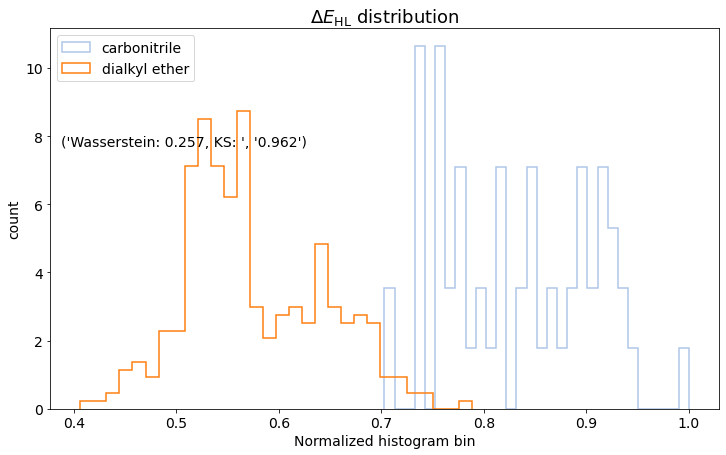

carbonitrile_enol ether_hlgaps.png


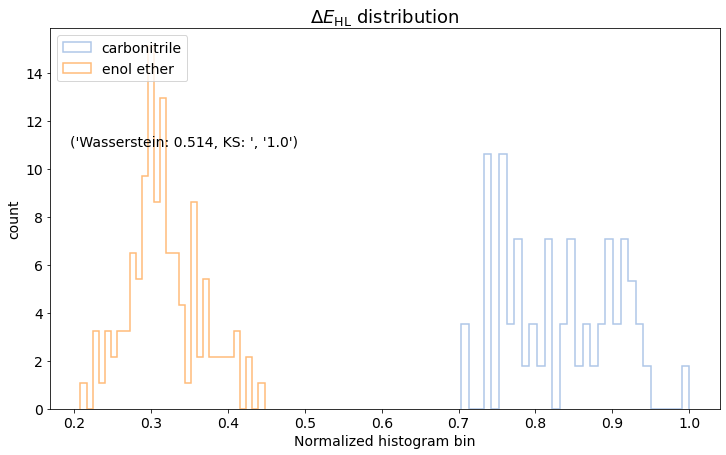

carbonitrile_hydrazone_hlgaps.png


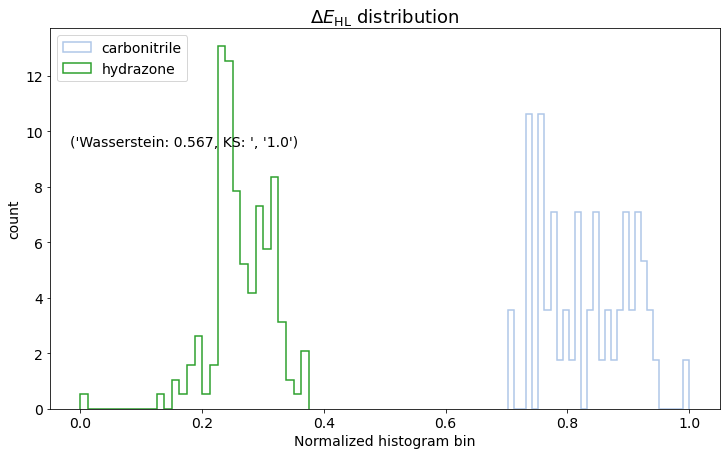

carbonitrile_ketone_hlgaps.png


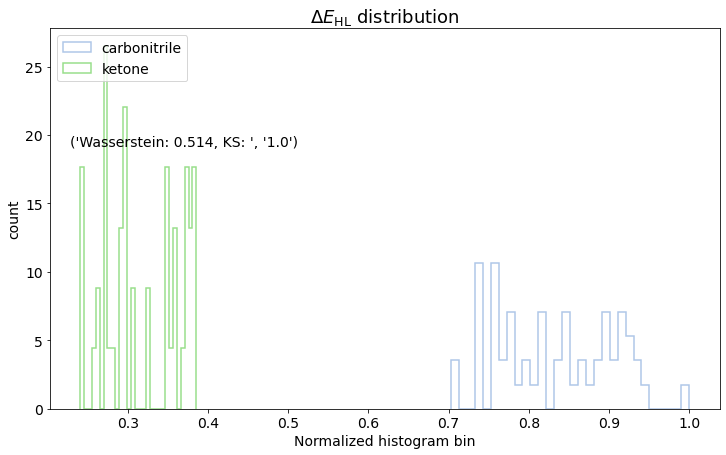

carbonitrile_oxime_hlgaps.png


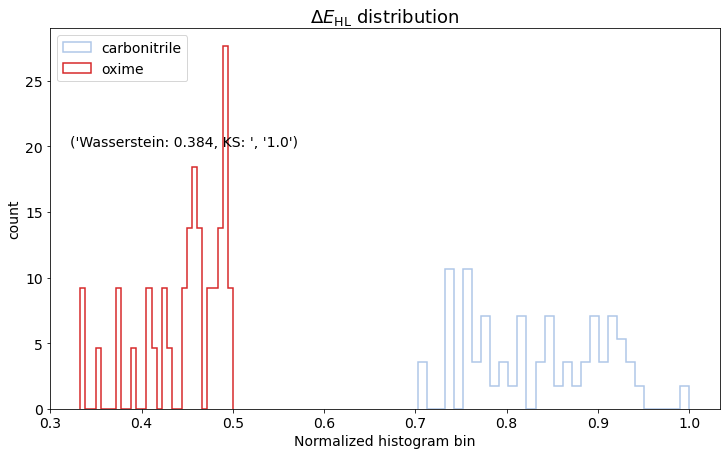

carbonitrile_primary alcohol_hlgaps.png


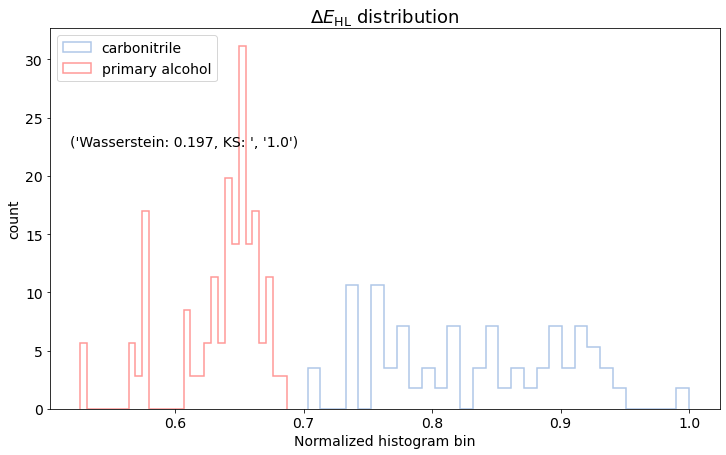

carbonitrile_primary aliphatic amine (alkylamine)_hlgaps.png


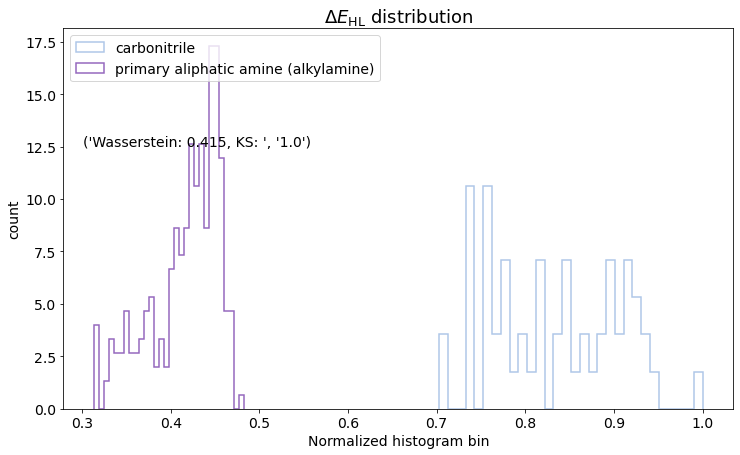

carbonitrile_secondary alcohol_hlgaps.png


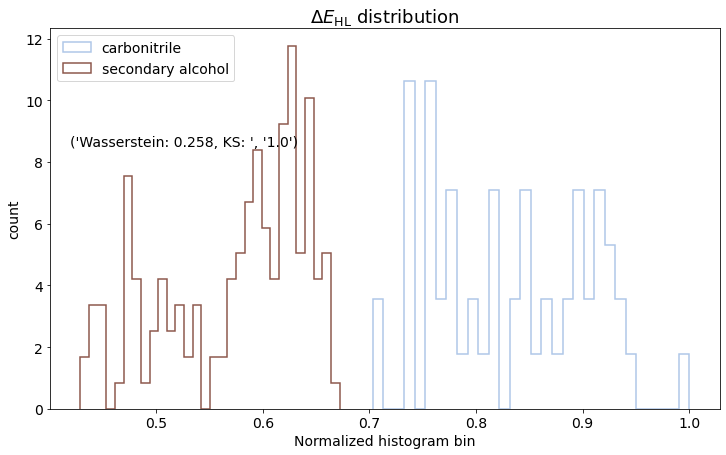

carbonitrile_secondary aliphatic amine (dialkylamine)_hlgaps.png


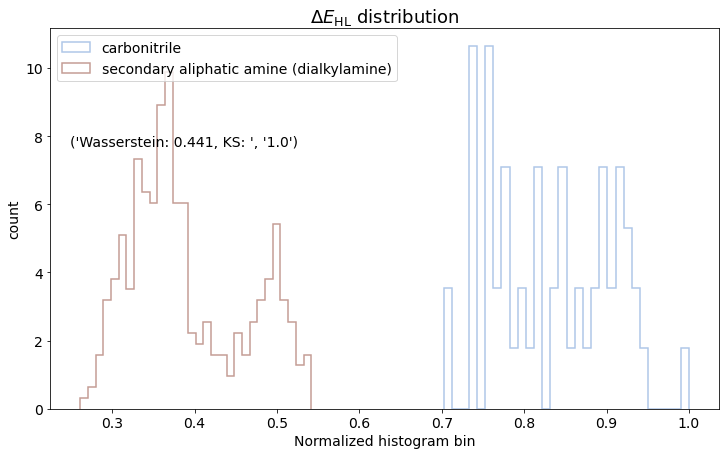

dialkyl ether_enol ether_hlgaps.png


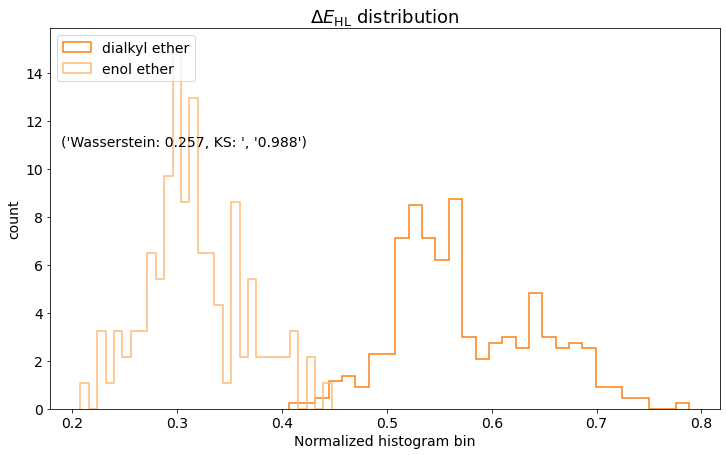

dialkyl ether_hydrazone_hlgaps.png


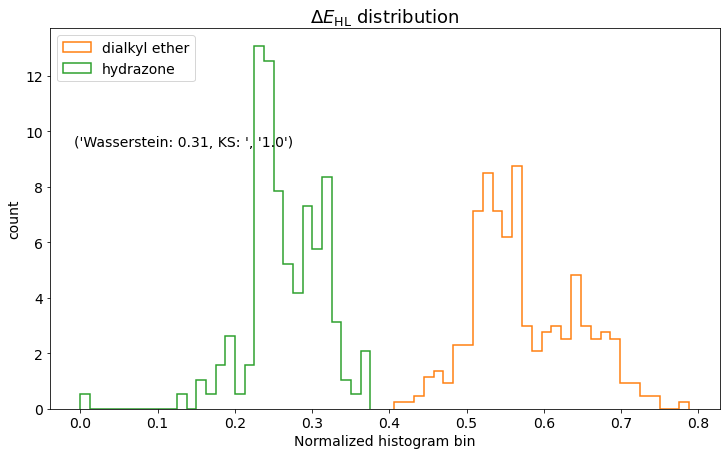

dialkyl ether_ketone_hlgaps.png


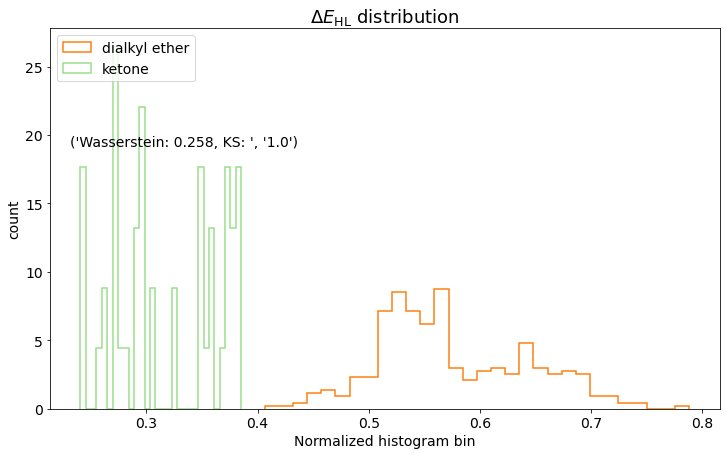

dialkyl ether_oxime_hlgaps.png


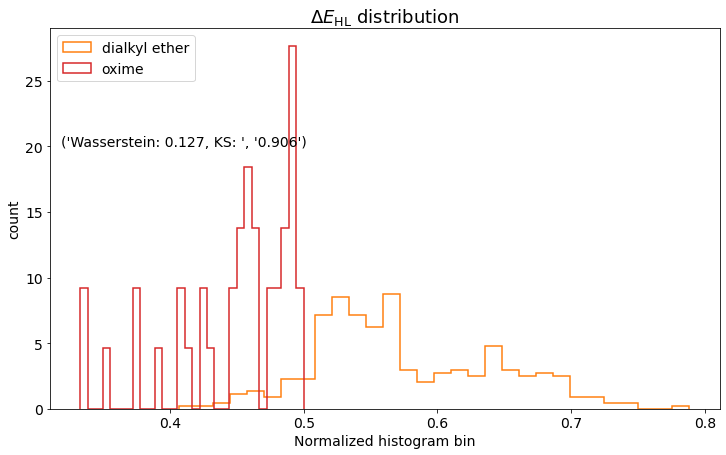

dialkyl ether_primary alcohol_hlgaps.png


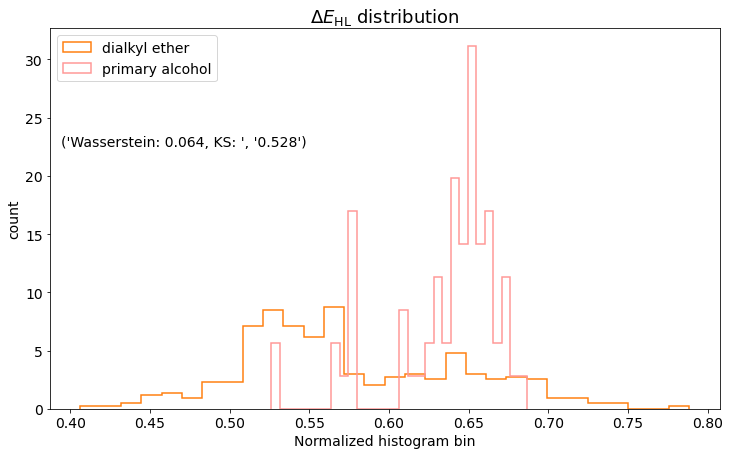

dialkyl ether_primary aliphatic amine (alkylamine)_hlgaps.png


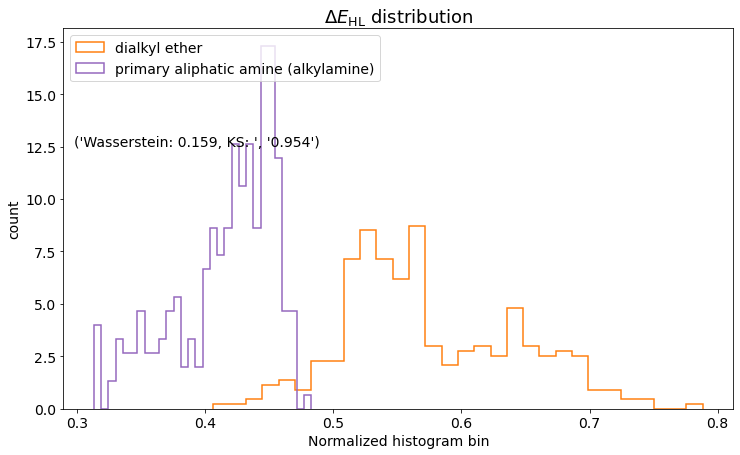

dialkyl ether_secondary alcohol_hlgaps.png


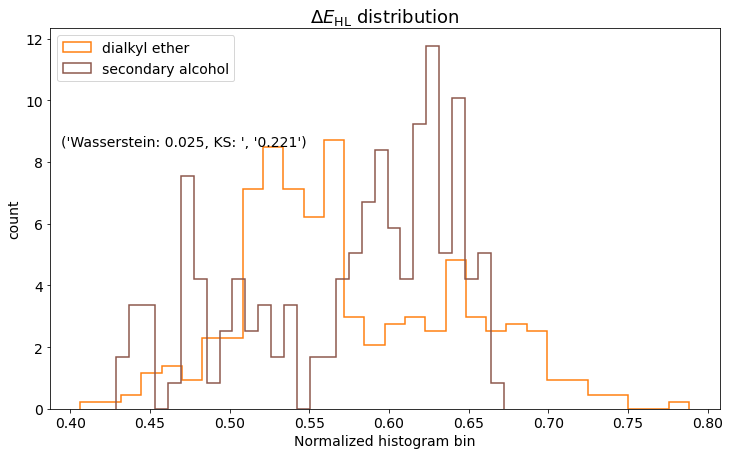

dialkyl ether_secondary aliphatic amine (dialkylamine)_hlgaps.png


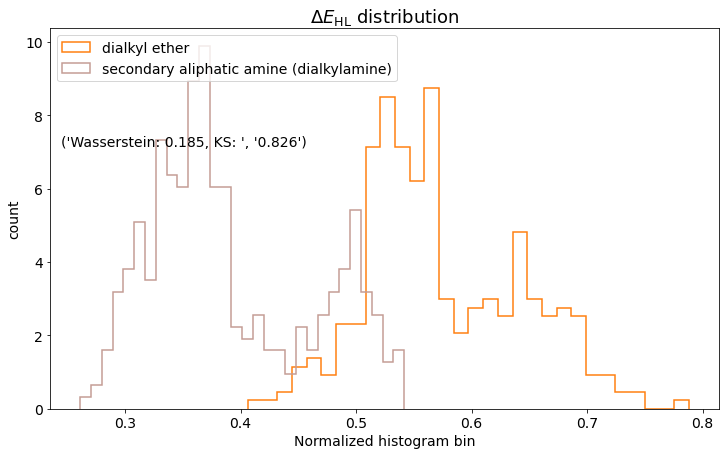

enol ether_hydrazone_hlgaps.png


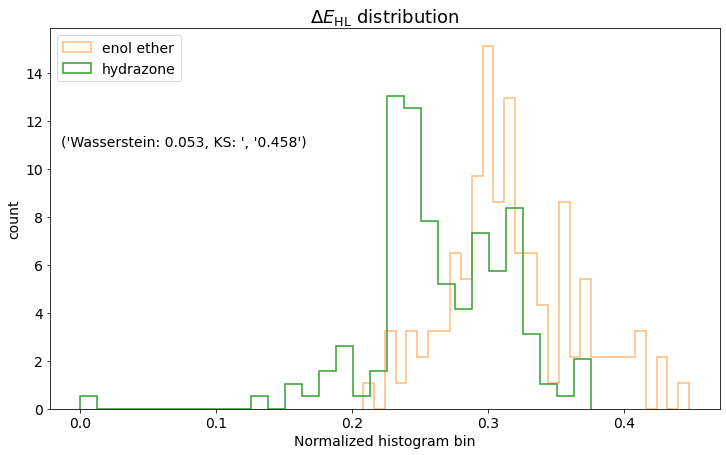

enol ether_ketone_hlgaps.png


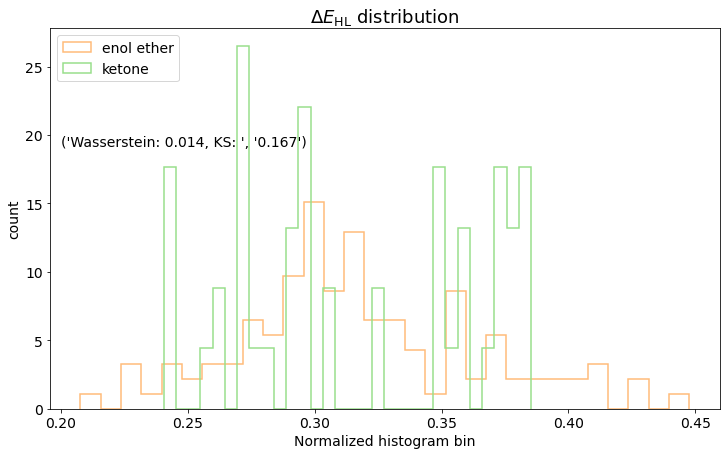

enol ether_oxime_hlgaps.png


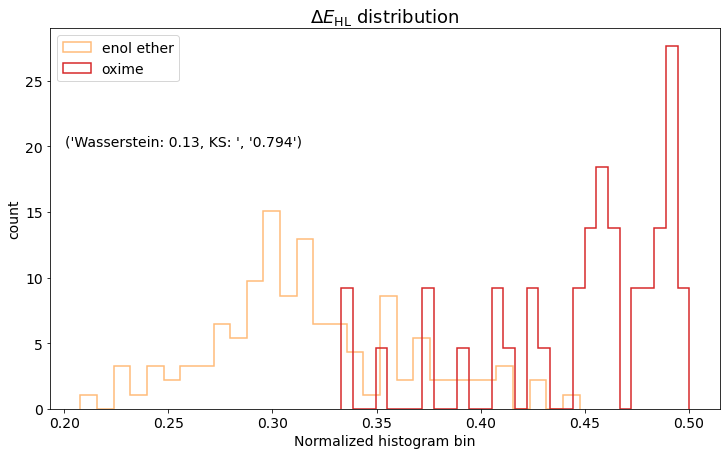

enol ether_primary alcohol_hlgaps.png


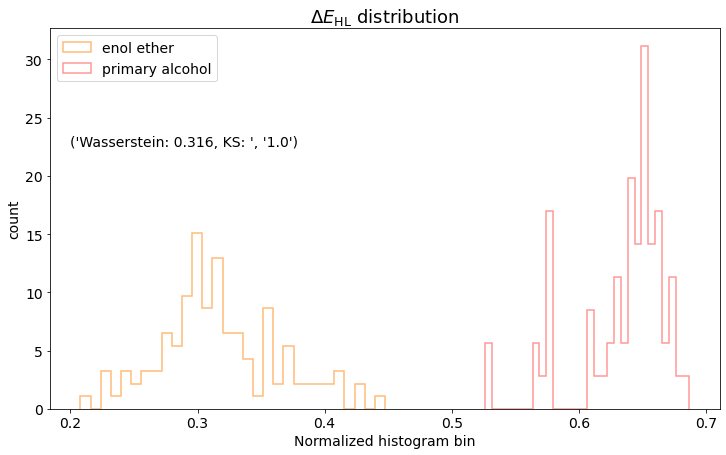

enol ether_primary aliphatic amine (alkylamine)_hlgaps.png


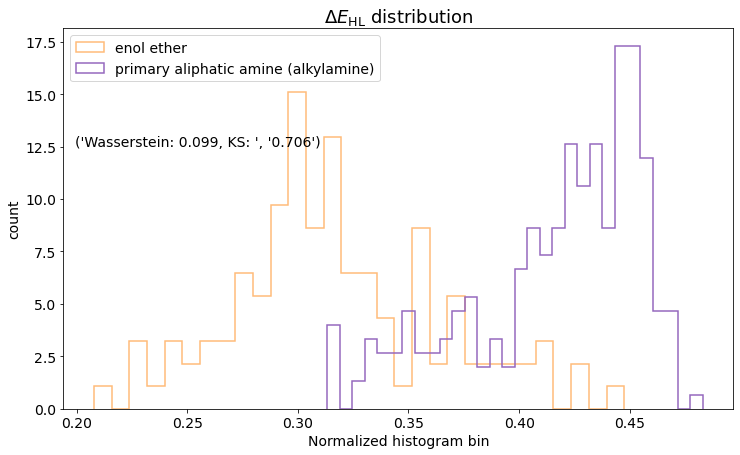

enol ether_secondary alcohol_hlgaps.png


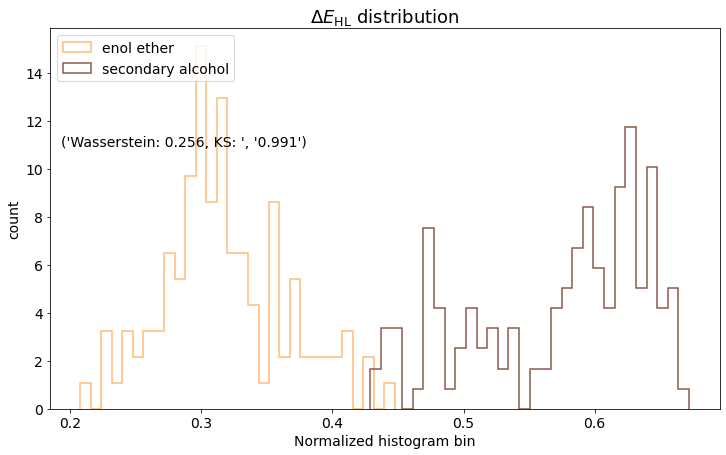

enol ether_secondary aliphatic amine (dialkylamine)_hlgaps.png


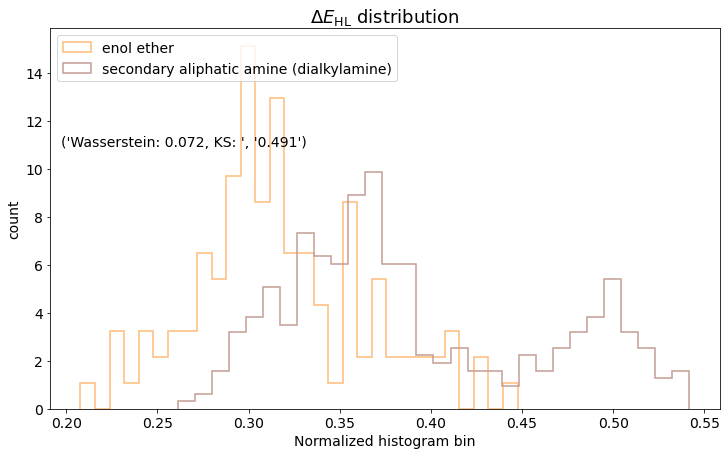

hydrazone_ketone_hlgaps.png


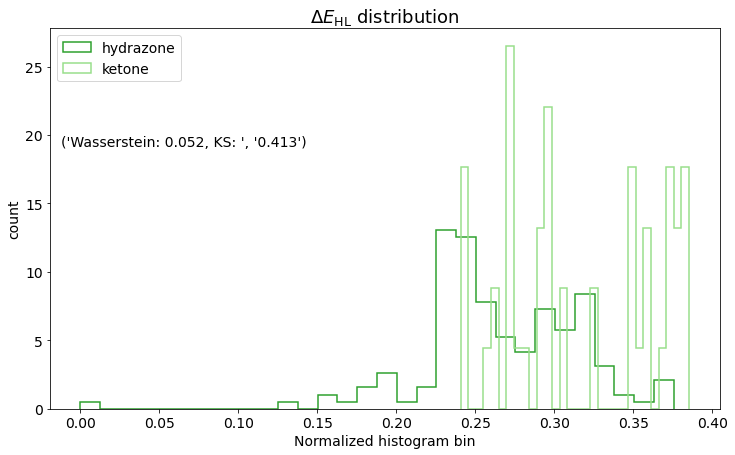

hydrazone_oxime_hlgaps.png


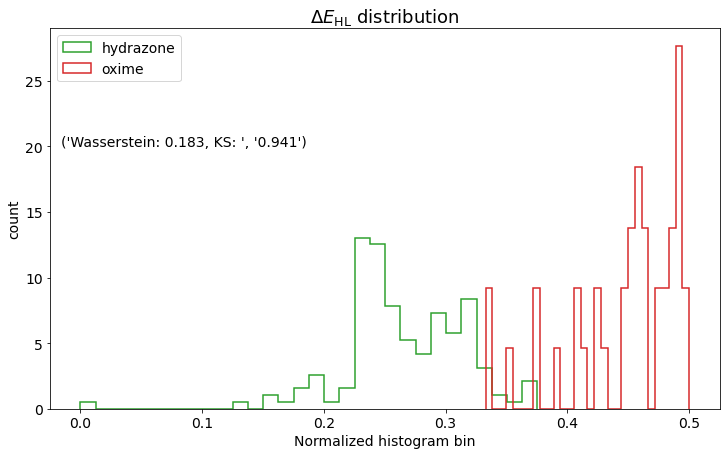

hydrazone_primary alcohol_hlgaps.png


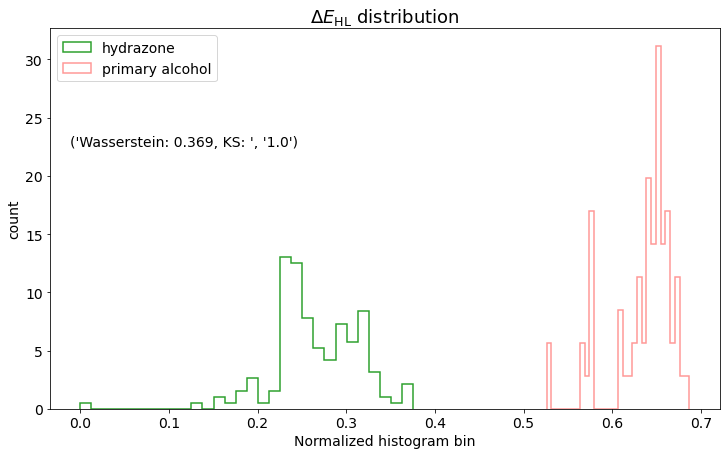

hydrazone_primary aliphatic amine (alkylamine)_hlgaps.png


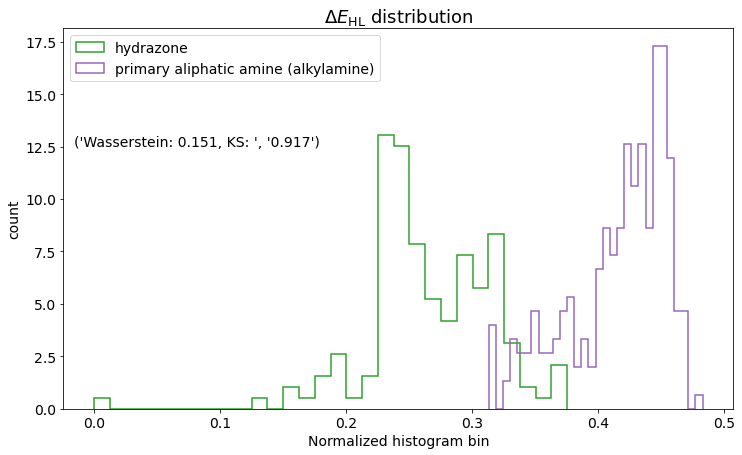

hydrazone_secondary alcohol_hlgaps.png


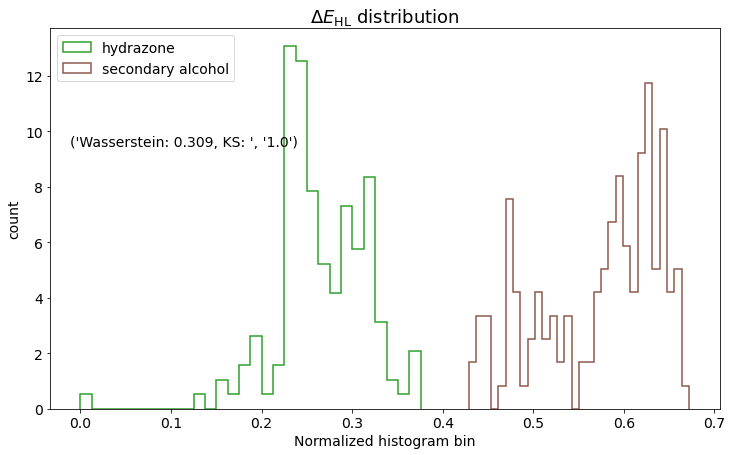

hydrazone_secondary aliphatic amine (dialkylamine)_hlgaps.png


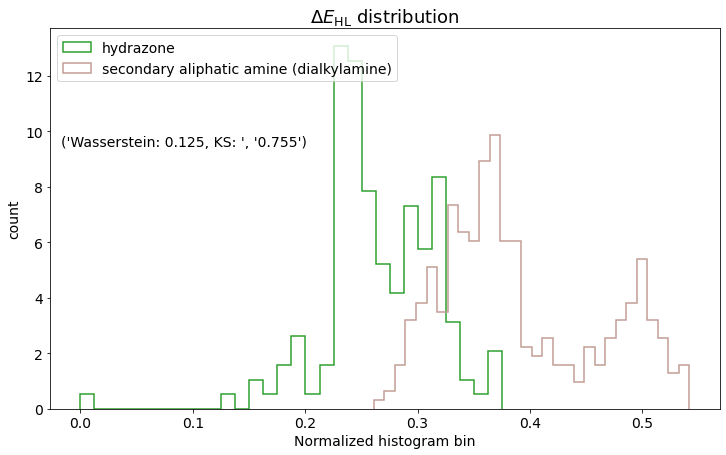

ketone_oxime_hlgaps.png


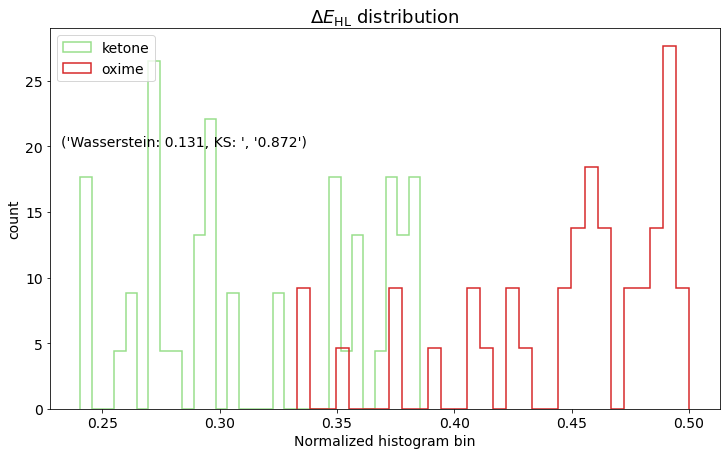

ketone_primary alcohol_hlgaps.png


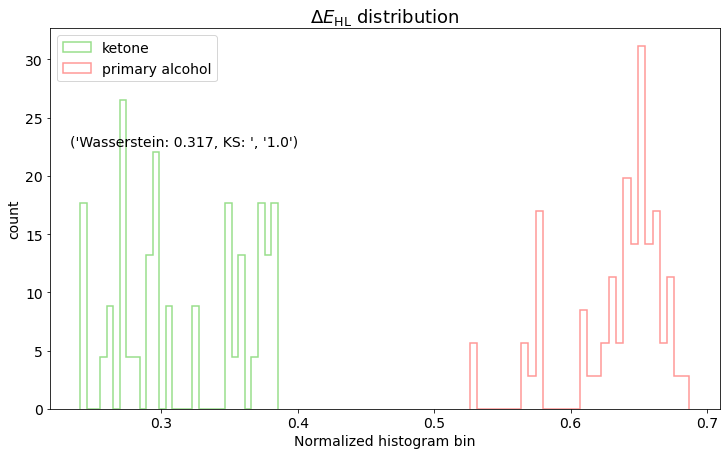

ketone_primary aliphatic amine (alkylamine)_hlgaps.png


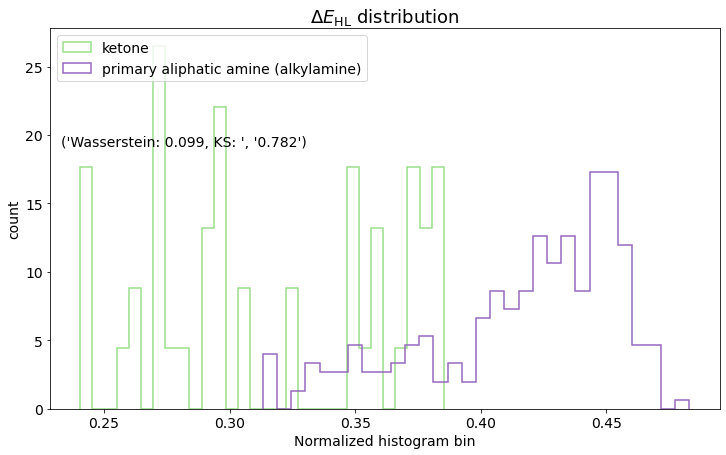

ketone_secondary alcohol_hlgaps.png


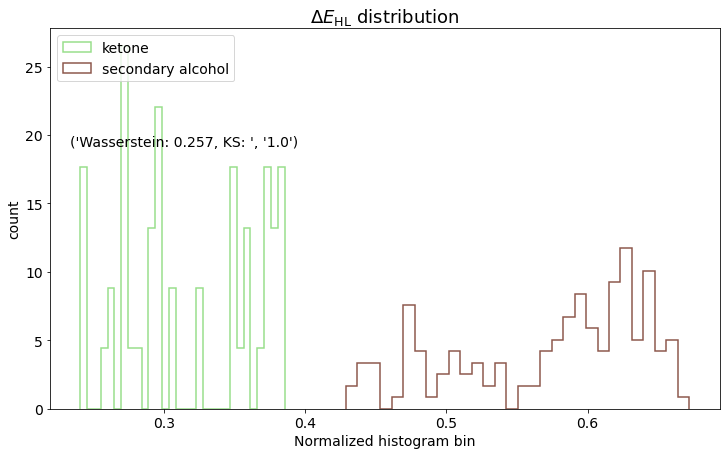

ketone_secondary aliphatic amine (dialkylamine)_hlgaps.png


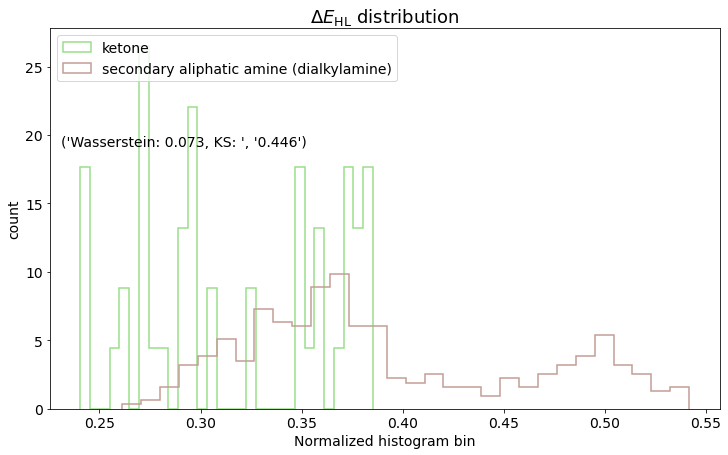

oxime_primary alcohol_hlgaps.png


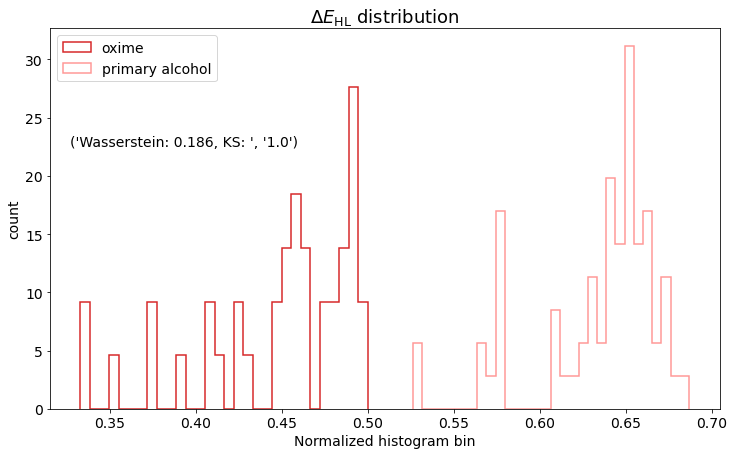

oxime_primary aliphatic amine (alkylamine)_hlgaps.png


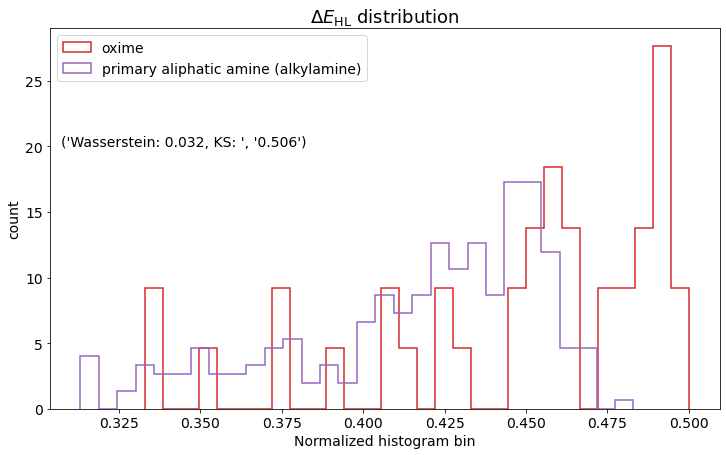

oxime_secondary alcohol_hlgaps.png


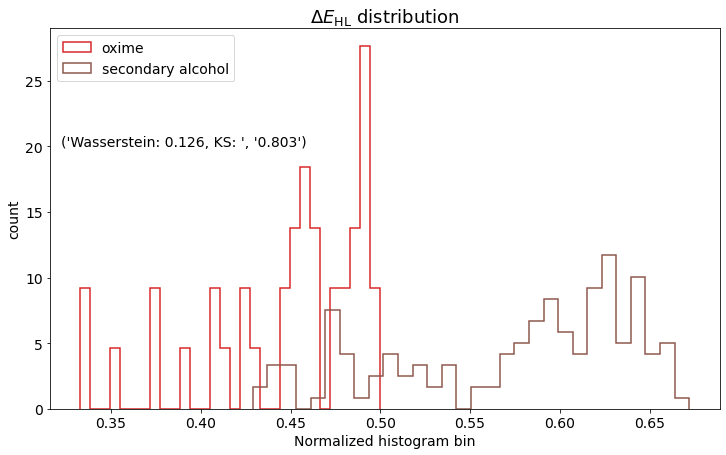

oxime_secondary aliphatic amine (dialkylamine)_hlgaps.png


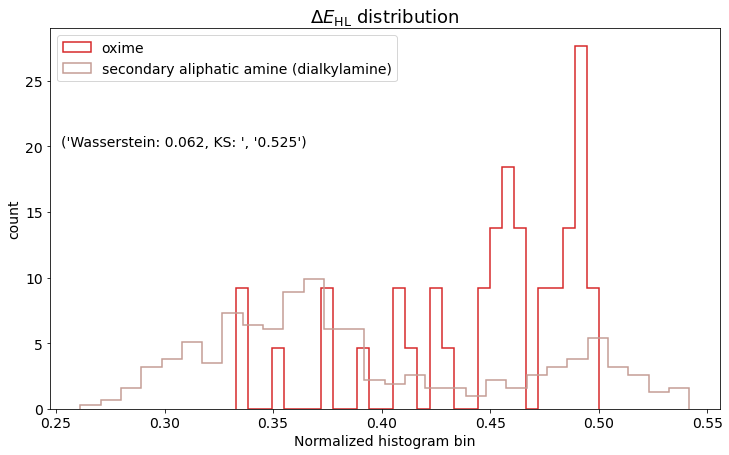

primary alcohol_primary aliphatic amine (alkylamine)_hlgaps.png


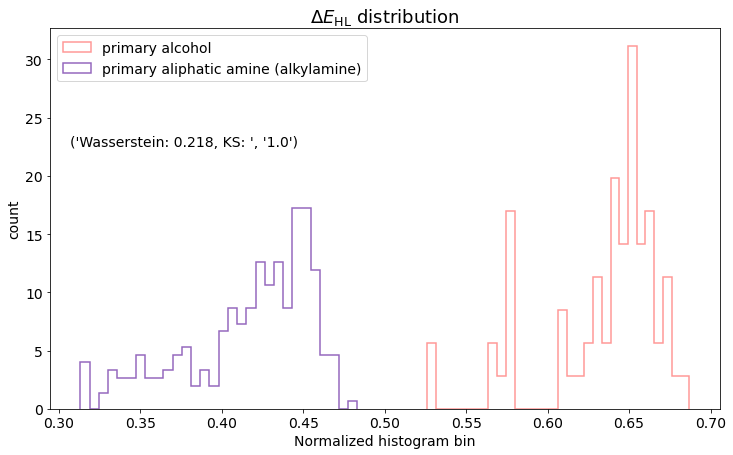

primary alcohol_secondary alcohol_hlgaps.png


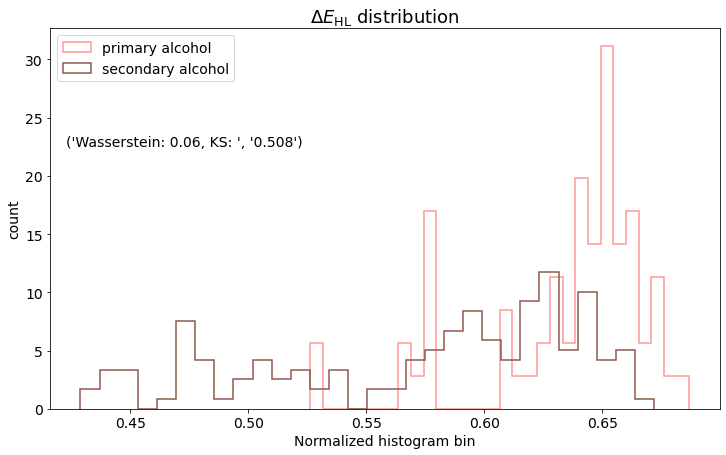

primary alcohol_secondary aliphatic amine (dialkylamine)_hlgaps.png


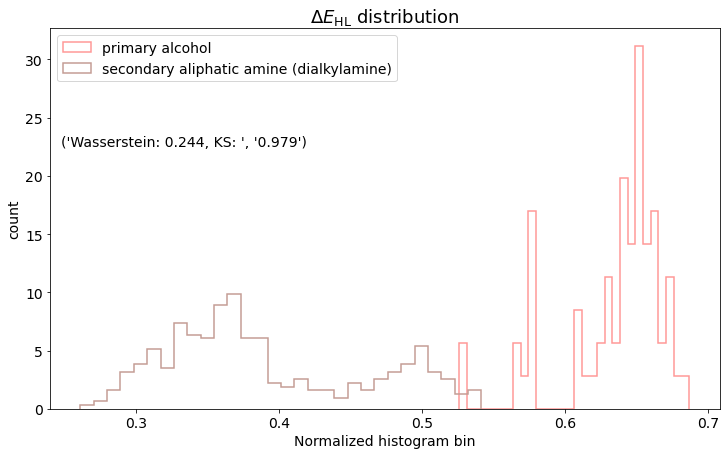

primary aliphatic amine (alkylamine)_secondary alcohol_hlgaps.png


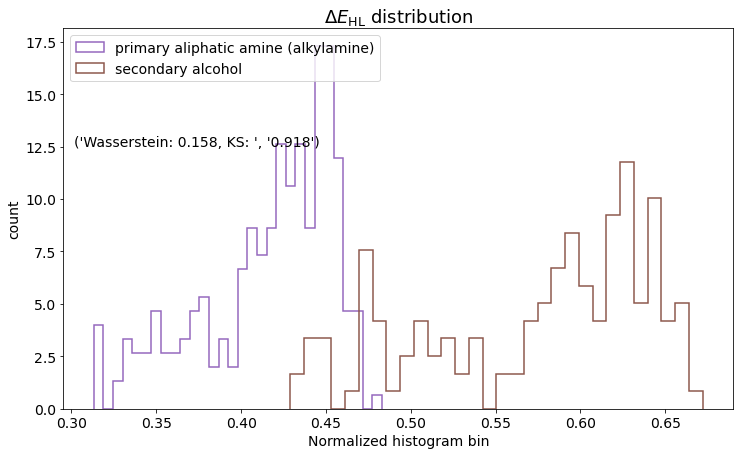

primary aliphatic amine (alkylamine)_secondary aliphatic amine (dialkylamine)_hlgaps.png


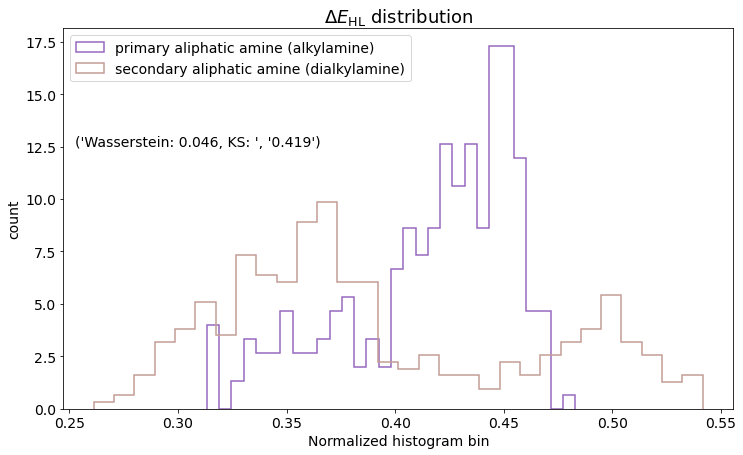

secondary alcohol_secondary aliphatic amine (dialkylamine)_hlgaps.png


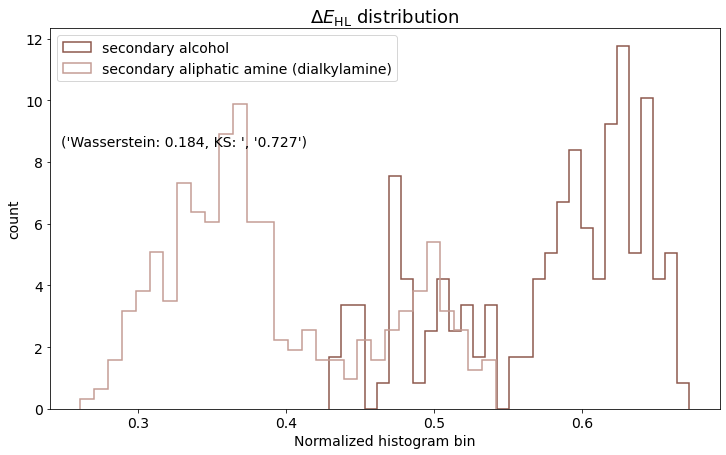

In [28]:
# For statistics, we need the HLgaps and alphas for the reduced dataset

flat_pruned_hlgaps = [point["hlgap"] for point in single_groups]


# Creating histograms along the HLgap axis to show that they are statistically very different

list_of_hists = []


# We will have two measures of statistical distance: Wasserstein and Kolmogorov-Smirnov distances
hlgap_pair_wasserstein,hlgap_pair_ks  = [],[]


# Generating all possible pairs
for pair in itertools.combinations(range(len(chosen_groups)),2):
    # normalizing the data
    norm1 = np.asarray( (hlgaps_fcngroup[pair[0]] - np.min(flat_pruned_hlgaps))/(np.max(flat_pruned_hlgaps)-np.min(flat_pruned_hlgaps)))
    norm2 = np.asarray( (hlgaps_fcngroup[pair[1]] - np.min(flat_pruned_hlgaps))/(np.max(flat_pruned_hlgaps)-np.min(flat_pruned_hlgaps)))
   
    hist1 = plt.hist(norm1,bins=30,histtype='step',color=colors[pair[0]], density=True,  linewidth=1.5, label=chosen_groups[pair[0]])
    hist2 = plt.hist(norm2,bins=30,histtype='step',color=colors[pair[1]], density=True,  linewidth=1.5, label=chosen_groups[pair[1]])
    
    plt.legend(loc="upper left",fontsize=14)
    plt.xlabel(r"Normalized histogram bin",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(r"$\Delta E_{\mathrm{HL}}$ distribution",fontsize=18)

    
    #adding some statistical numbers right onto the plot
    string="Wasserstein: "+str(round(wasserstein_distance(norm1,norm2),3)) +", KS: ", str(round(stats.ks_2samp(norm1,norm2)[0],3))
    plt.text(0.2,0.7, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)
    hlgap_pair_wasserstein.append(wasserstein_distance(norm1,norm2))
    hlgap_pair_ks.append(stats.ks_2samp(norm1,norm2)[0])
    plotname_string=chosen_groups[pair[0]]+"_"+chosen_groups[pair[1]]+"_hlgaps.png"
    #plt.savefig(plotname_string)
    print(plotname_string)
    plt.show()


aldehyde_carbonitrile_alphas.png
aldehyde_carbonitrile_alphas.png


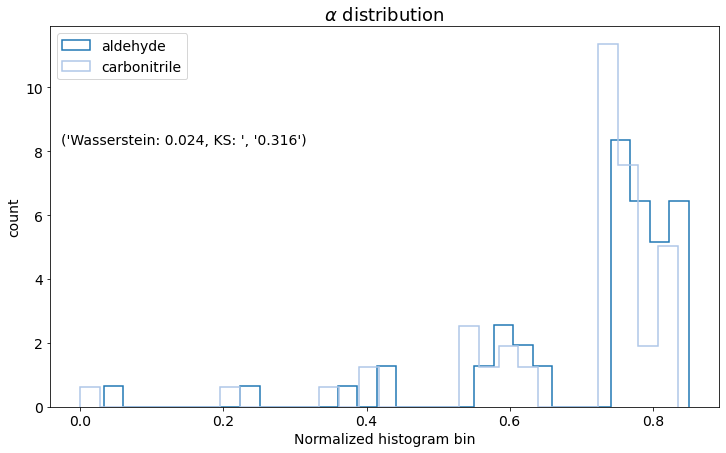

aldehyde_dialkyl ether_alphas.png
aldehyde_dialkyl ether_alphas.png


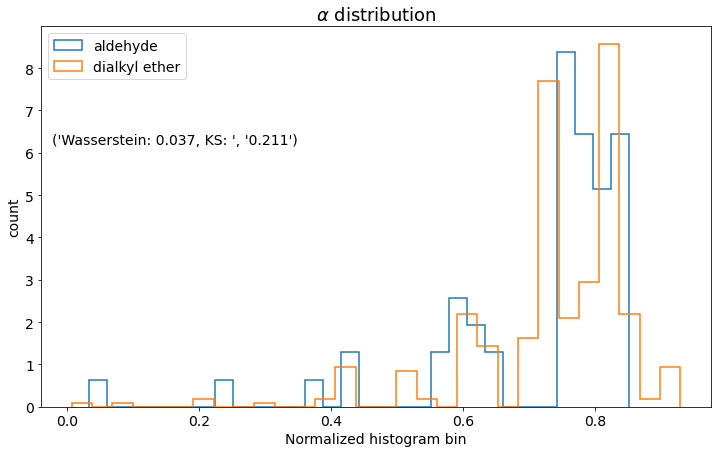

aldehyde_enol ether_alphas.png
aldehyde_enol ether_alphas.png


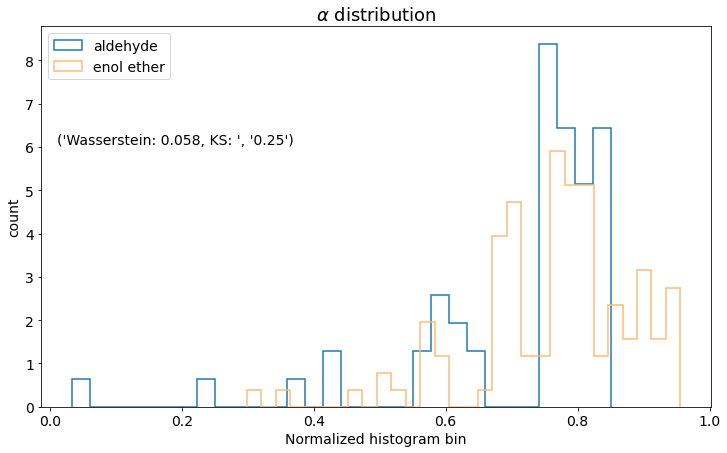

aldehyde_hydrazone_alphas.png
aldehyde_hydrazone_alphas.png


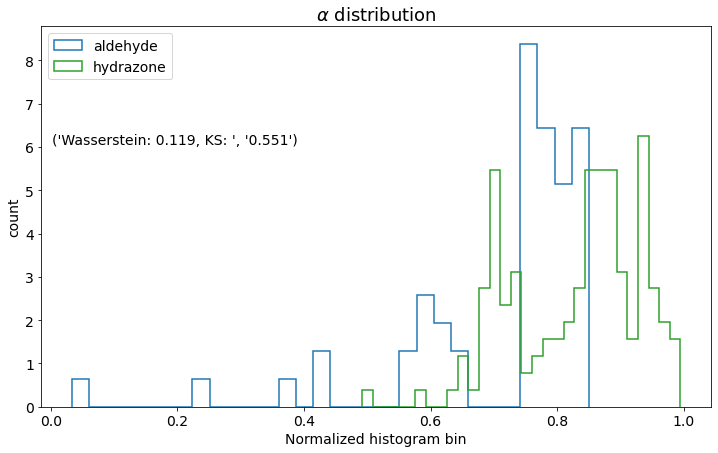

aldehyde_ketone_alphas.png
aldehyde_ketone_alphas.png


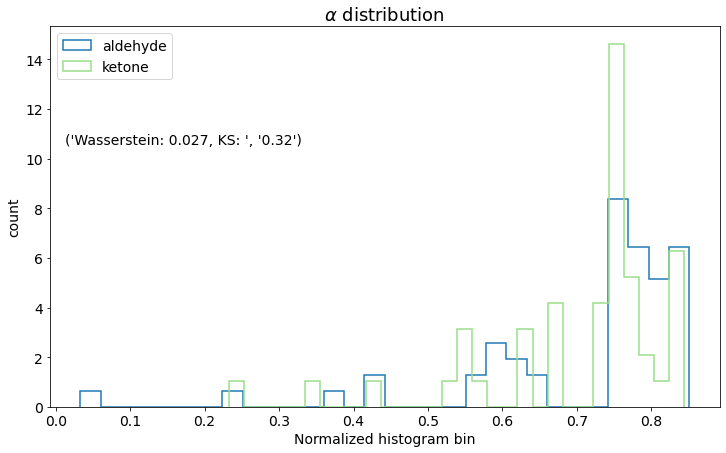

aldehyde_oxime_alphas.png
aldehyde_oxime_alphas.png


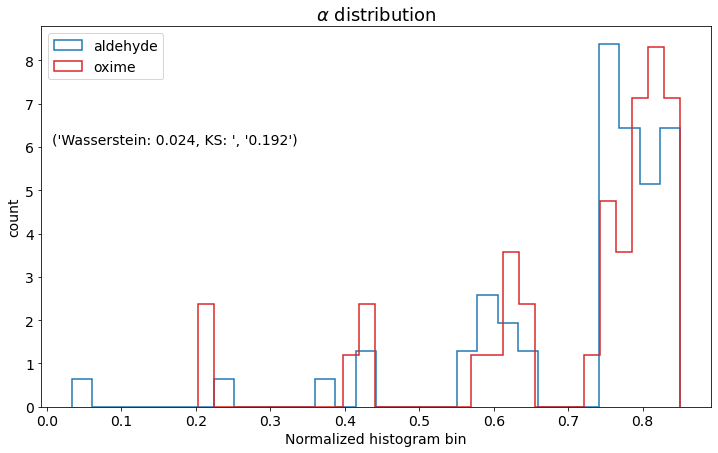

aldehyde_primary alcohol_alphas.png
aldehyde_primary alcohol_alphas.png


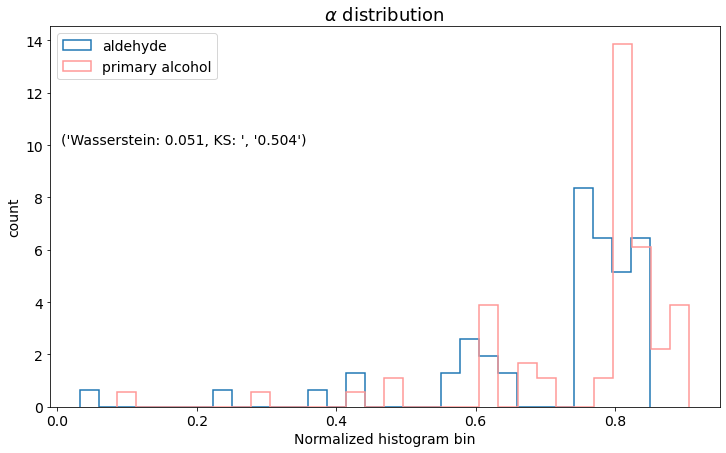

aldehyde_primary aliphatic amine (alkylamine)_alphas.png
aldehyde_primary aliphatic amine (alkylamine)_alphas.png


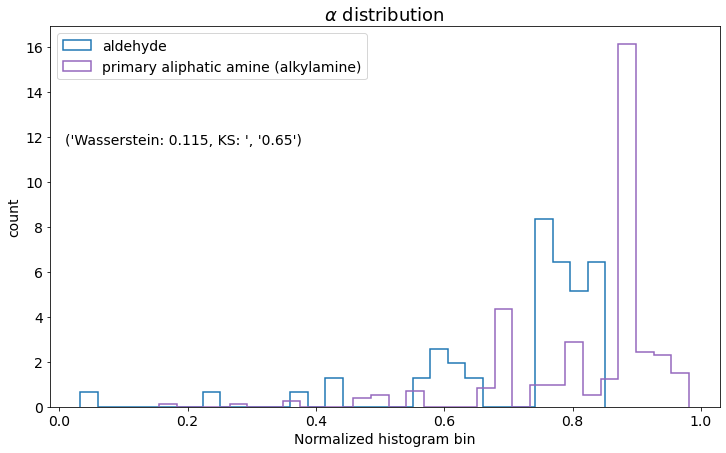

aldehyde_secondary alcohol_alphas.png
aldehyde_secondary alcohol_alphas.png


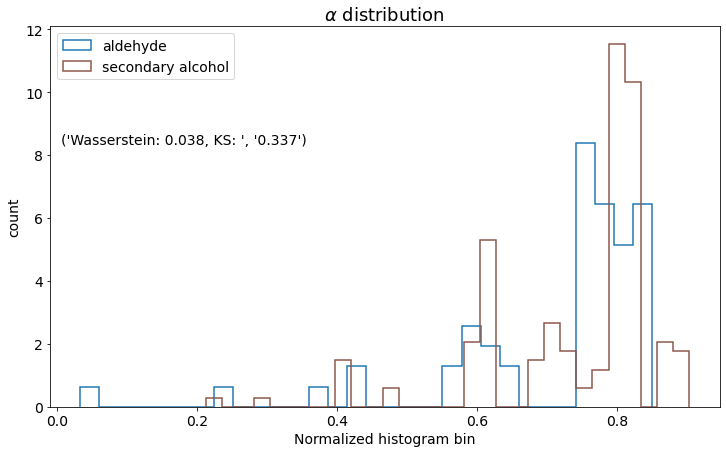

aldehyde_secondary aliphatic amine (dialkylamine)_alphas.png
aldehyde_secondary aliphatic amine (dialkylamine)_alphas.png


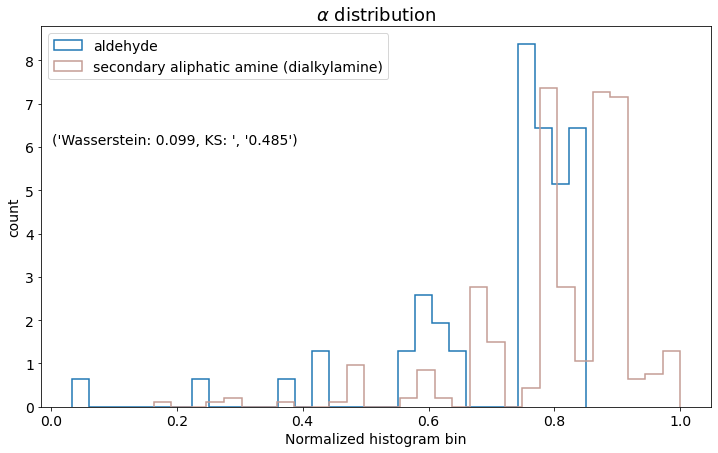

carbonitrile_dialkyl ether_alphas.png
carbonitrile_dialkyl ether_alphas.png


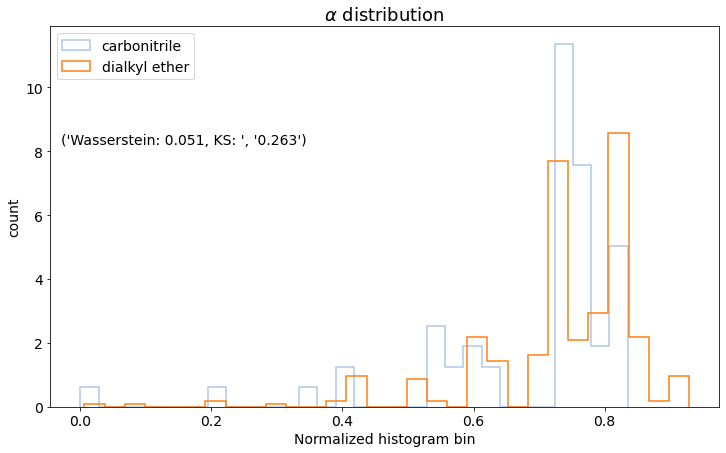

carbonitrile_enol ether_alphas.png
carbonitrile_enol ether_alphas.png


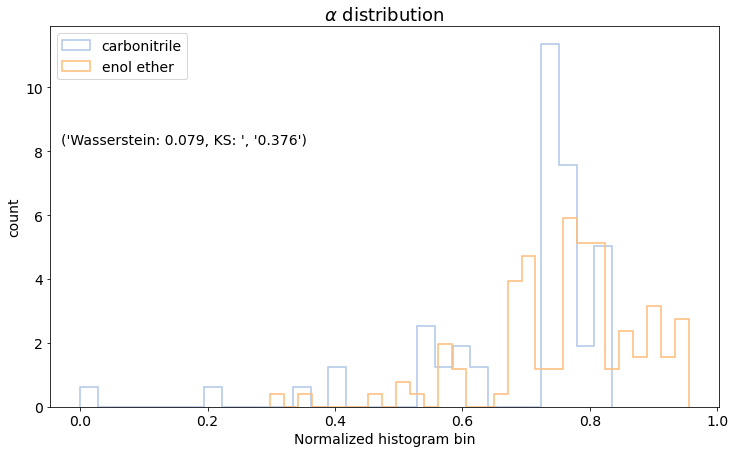

carbonitrile_hydrazone_alphas.png
carbonitrile_hydrazone_alphas.png


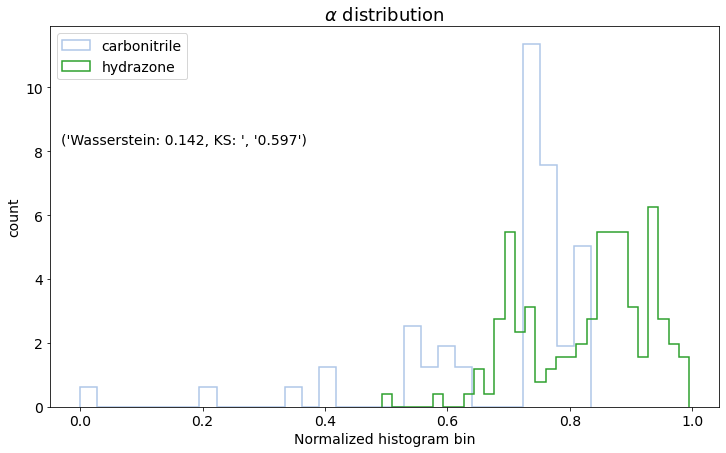

carbonitrile_ketone_alphas.png
carbonitrile_ketone_alphas.png


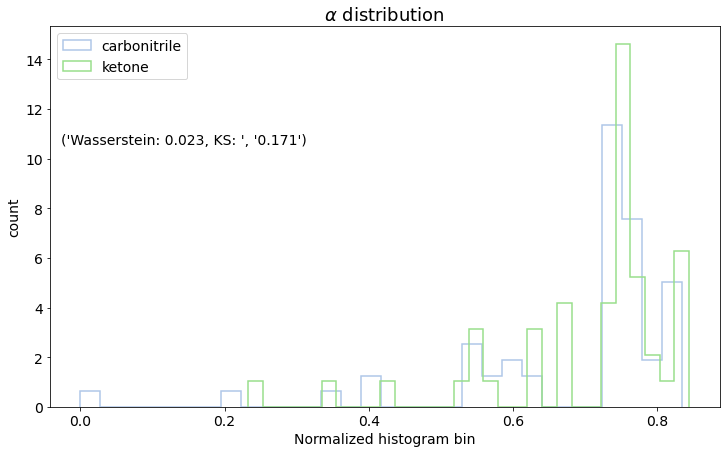

carbonitrile_oxime_alphas.png
carbonitrile_oxime_alphas.png


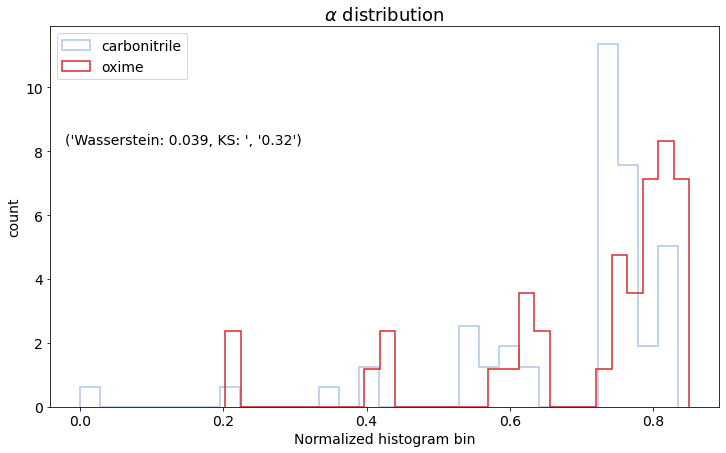

carbonitrile_primary alcohol_alphas.png
carbonitrile_primary alcohol_alphas.png


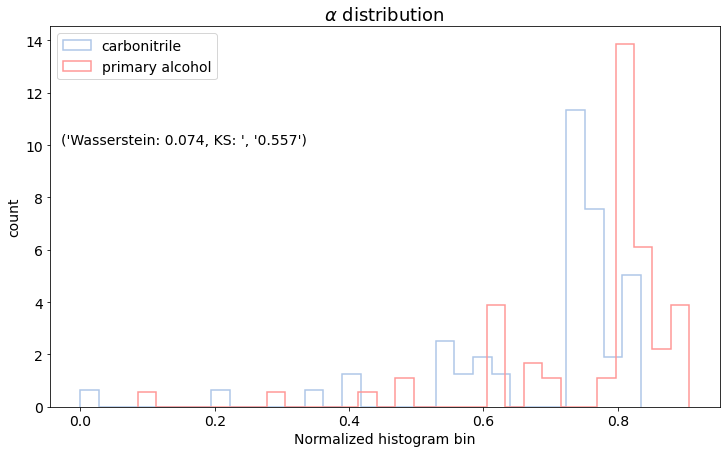

carbonitrile_primary aliphatic amine (alkylamine)_alphas.png
carbonitrile_primary aliphatic amine (alkylamine)_alphas.png


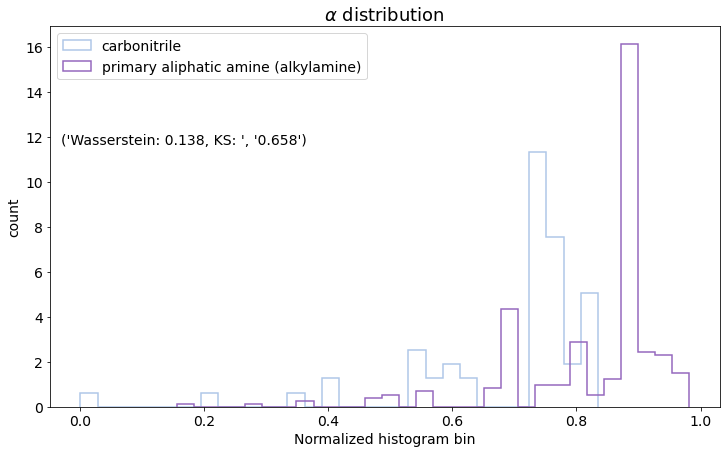

carbonitrile_secondary alcohol_alphas.png
carbonitrile_secondary alcohol_alphas.png


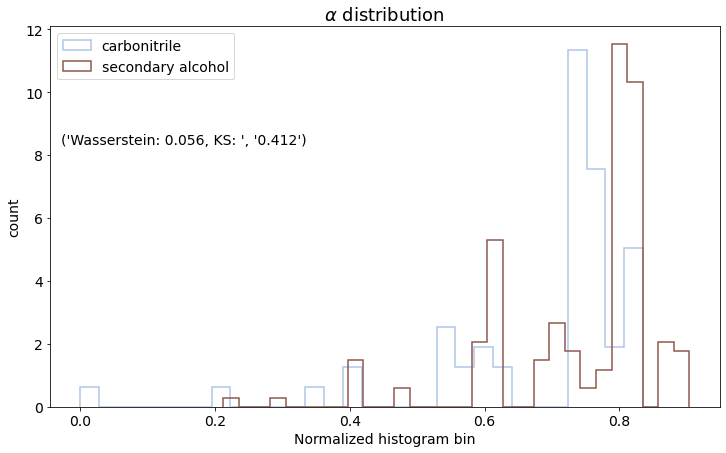

carbonitrile_secondary aliphatic amine (dialkylamine)_alphas.png
carbonitrile_secondary aliphatic amine (dialkylamine)_alphas.png


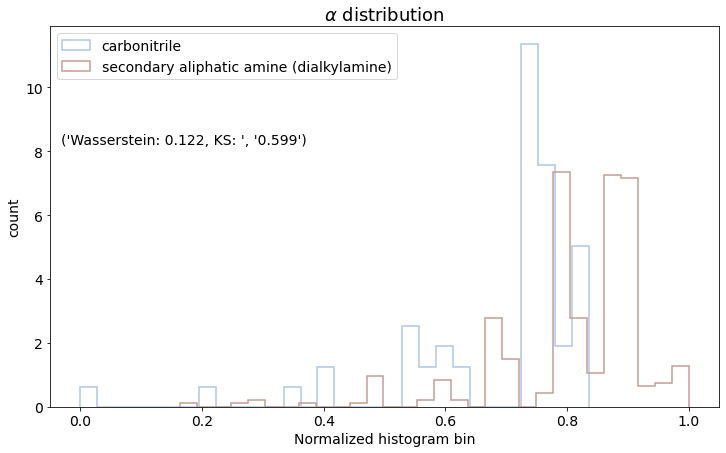

dialkyl ether_enol ether_alphas.png
dialkyl ether_enol ether_alphas.png


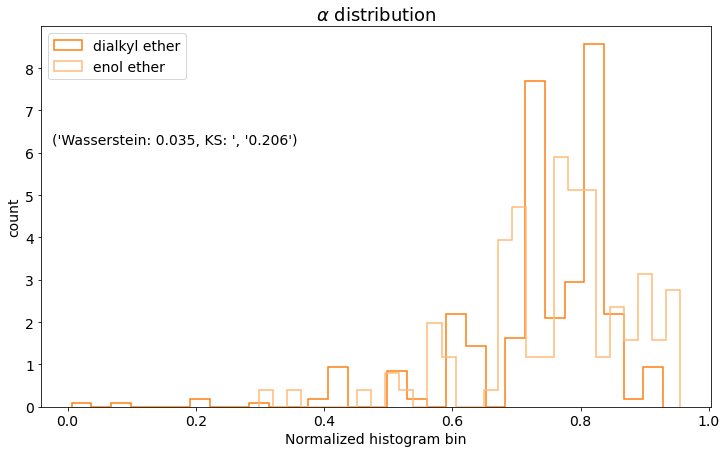

dialkyl ether_hydrazone_alphas.png
dialkyl ether_hydrazone_alphas.png


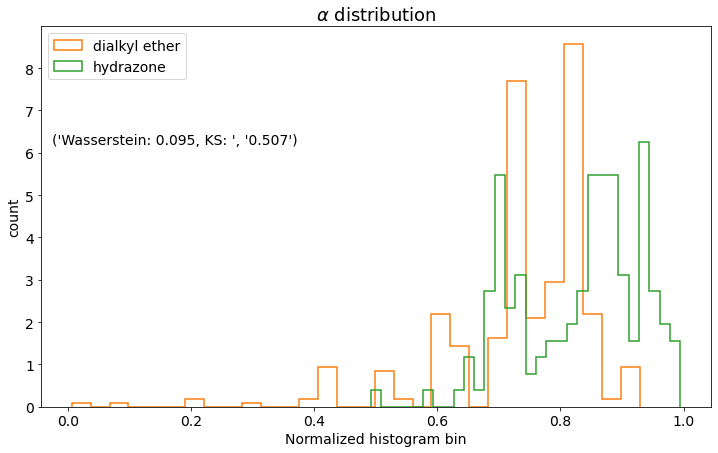

dialkyl ether_ketone_alphas.png
dialkyl ether_ketone_alphas.png


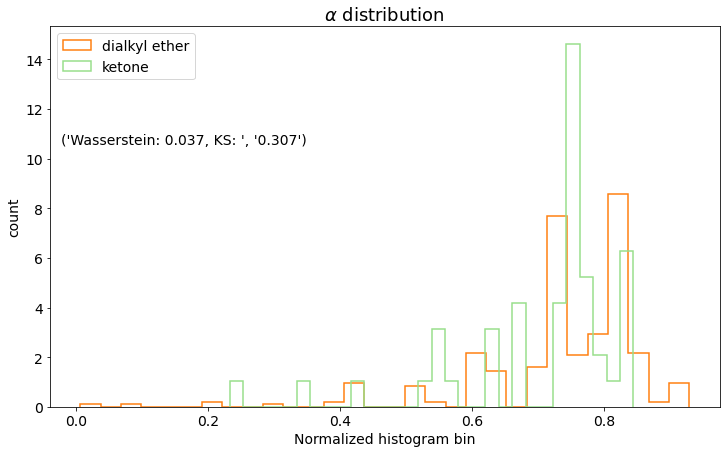

dialkyl ether_oxime_alphas.png
dialkyl ether_oxime_alphas.png


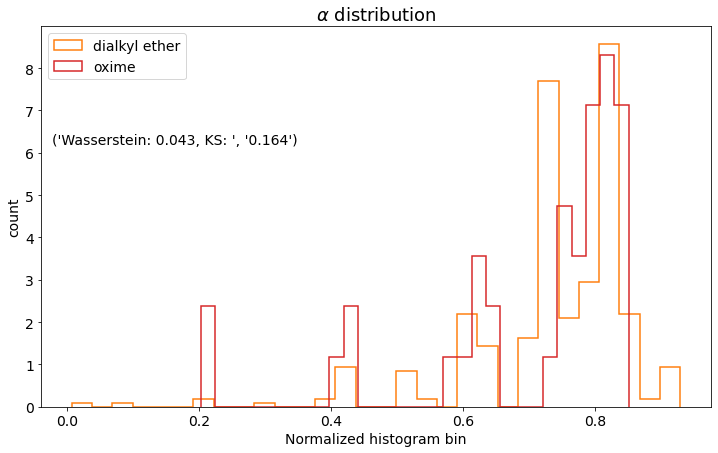

dialkyl ether_primary alcohol_alphas.png
dialkyl ether_primary alcohol_alphas.png


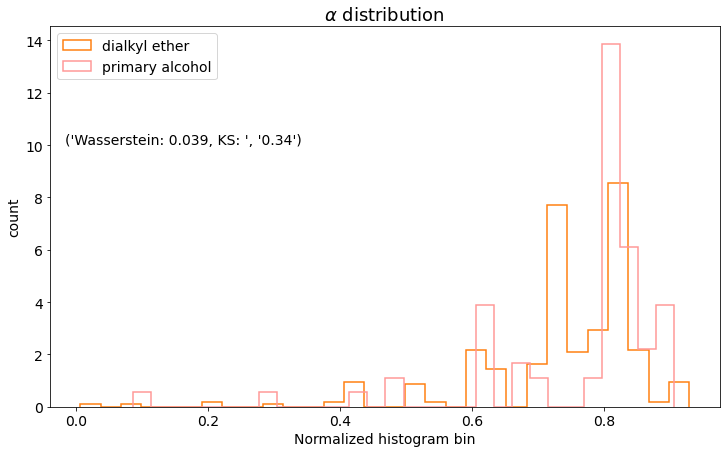

dialkyl ether_primary aliphatic amine (alkylamine)_alphas.png
dialkyl ether_primary aliphatic amine (alkylamine)_alphas.png


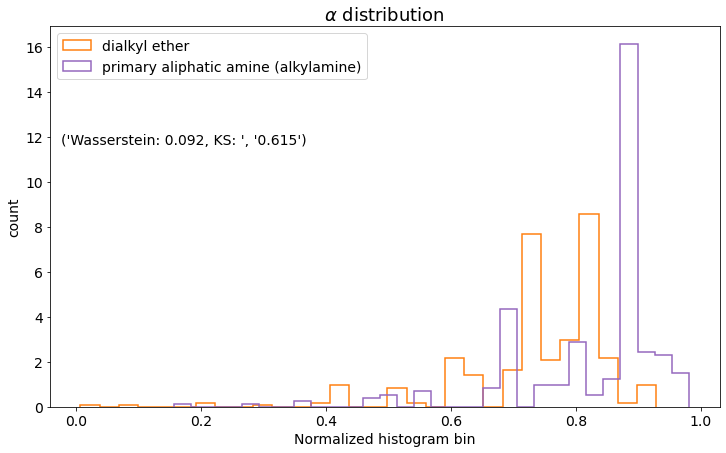

dialkyl ether_secondary alcohol_alphas.png
dialkyl ether_secondary alcohol_alphas.png


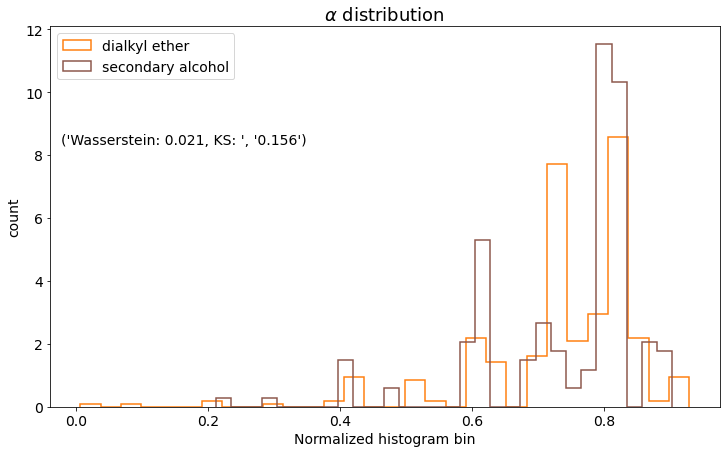

dialkyl ether_secondary aliphatic amine (dialkylamine)_alphas.png
dialkyl ether_secondary aliphatic amine (dialkylamine)_alphas.png


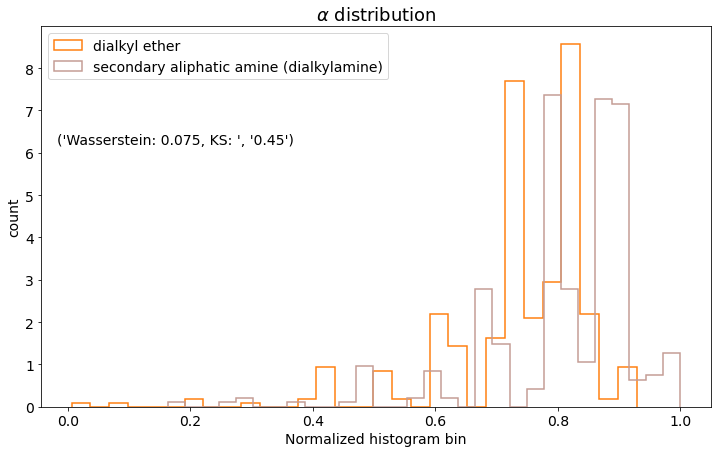

enol ether_hydrazone_alphas.png
enol ether_hydrazone_alphas.png


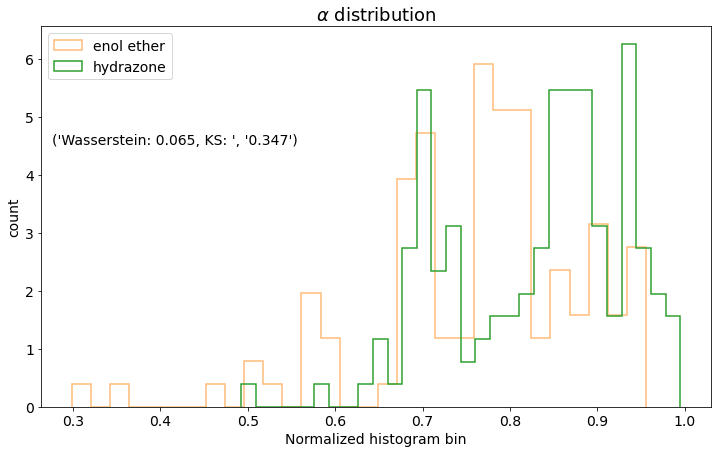

enol ether_ketone_alphas.png
enol ether_ketone_alphas.png


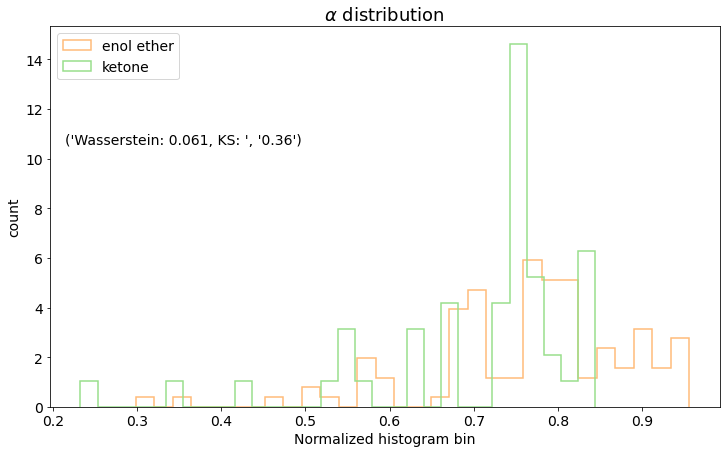

enol ether_oxime_alphas.png
enol ether_oxime_alphas.png


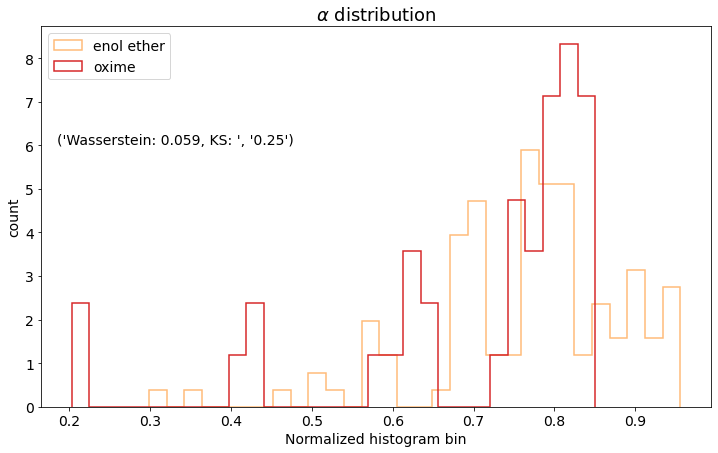

enol ether_primary alcohol_alphas.png
enol ether_primary alcohol_alphas.png


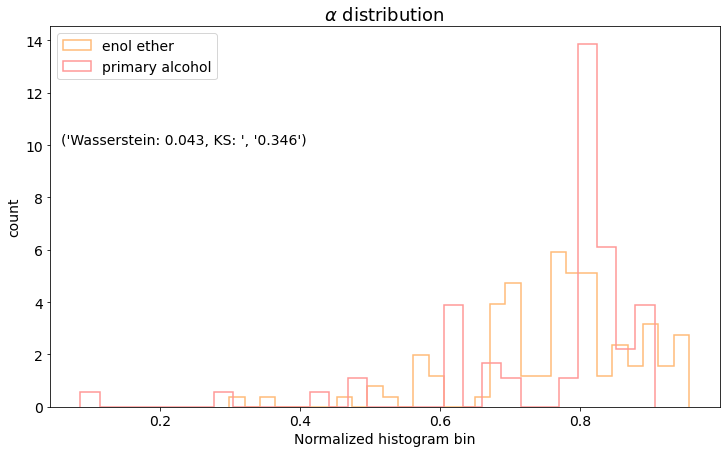

enol ether_primary aliphatic amine (alkylamine)_alphas.png
enol ether_primary aliphatic amine (alkylamine)_alphas.png


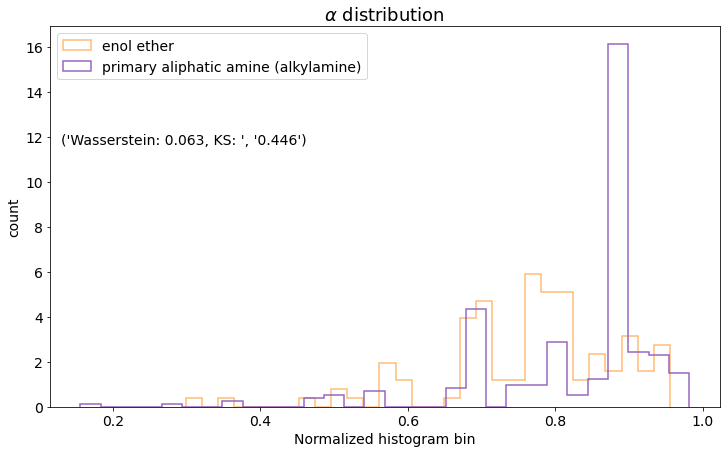

enol ether_secondary alcohol_alphas.png
enol ether_secondary alcohol_alphas.png


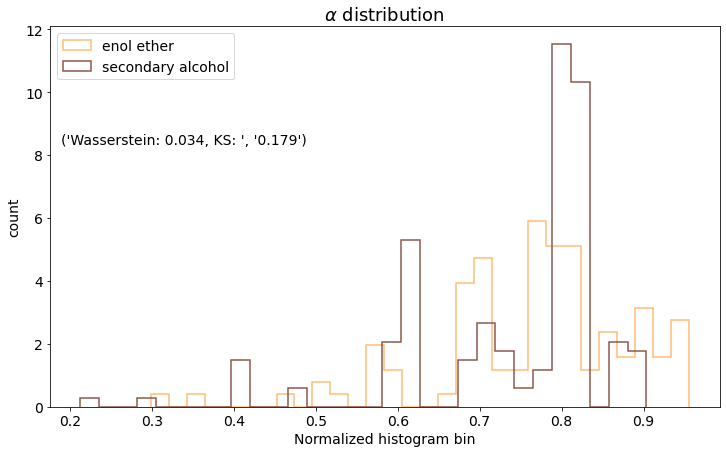

enol ether_secondary aliphatic amine (dialkylamine)_alphas.png
enol ether_secondary aliphatic amine (dialkylamine)_alphas.png


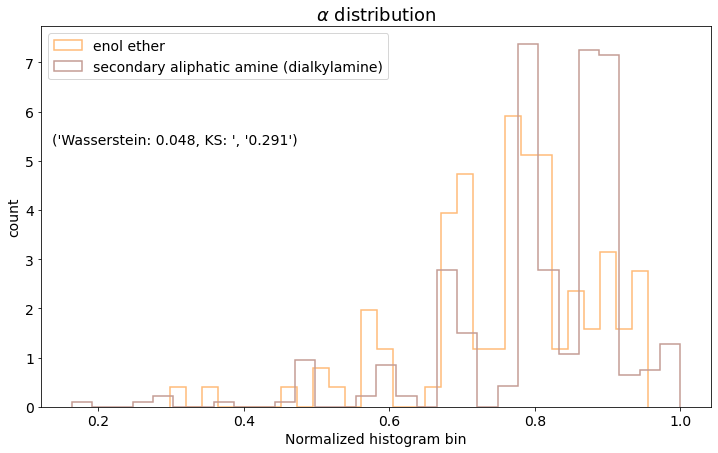

hydrazone_ketone_alphas.png
hydrazone_ketone_alphas.png


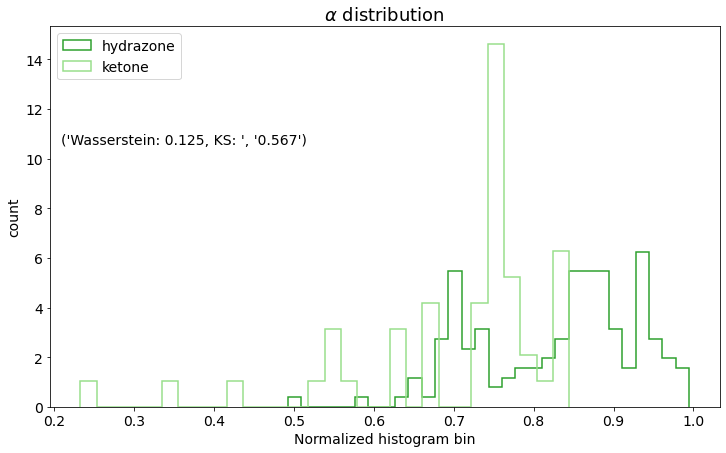

hydrazone_oxime_alphas.png
hydrazone_oxime_alphas.png


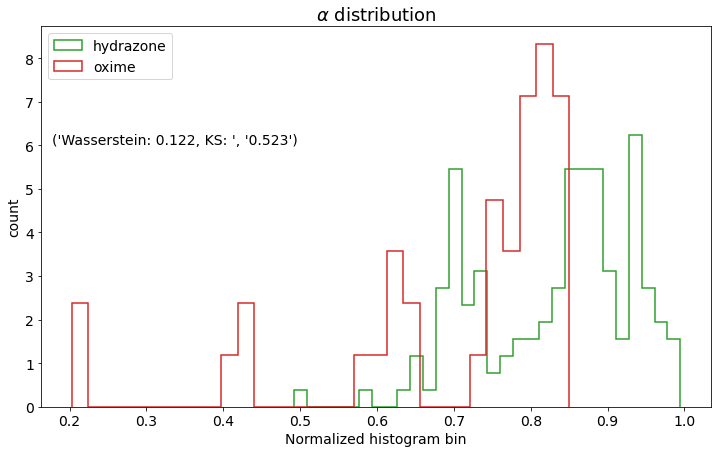

hydrazone_primary alcohol_alphas.png
hydrazone_primary alcohol_alphas.png


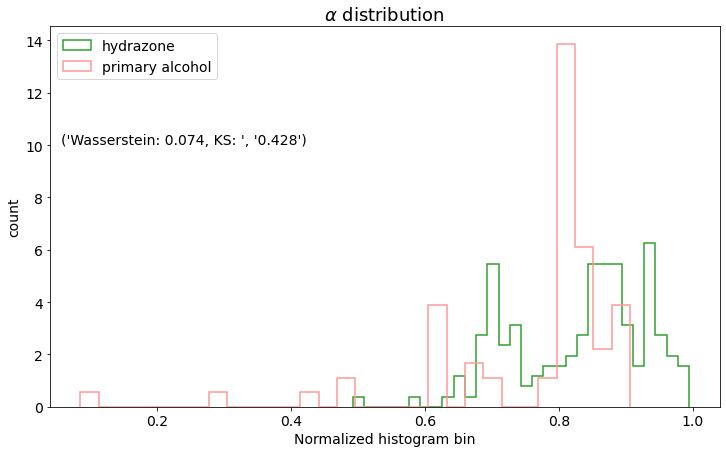

hydrazone_primary aliphatic amine (alkylamine)_alphas.png
hydrazone_primary aliphatic amine (alkylamine)_alphas.png


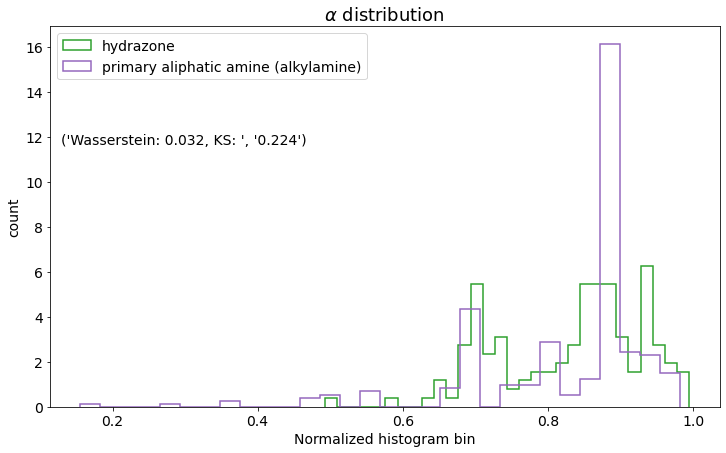

hydrazone_secondary alcohol_alphas.png
hydrazone_secondary alcohol_alphas.png


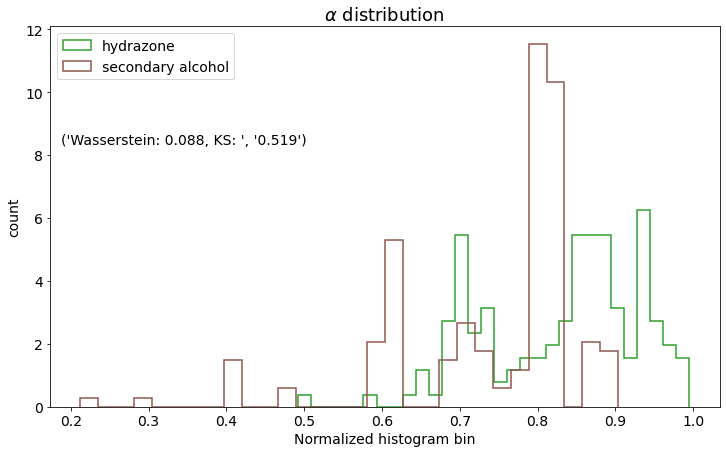

hydrazone_secondary aliphatic amine (dialkylamine)_alphas.png
hydrazone_secondary aliphatic amine (dialkylamine)_alphas.png


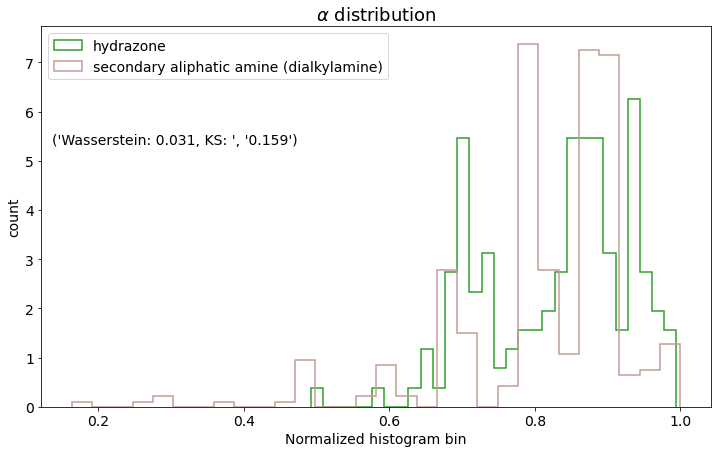

ketone_oxime_alphas.png
ketone_oxime_alphas.png


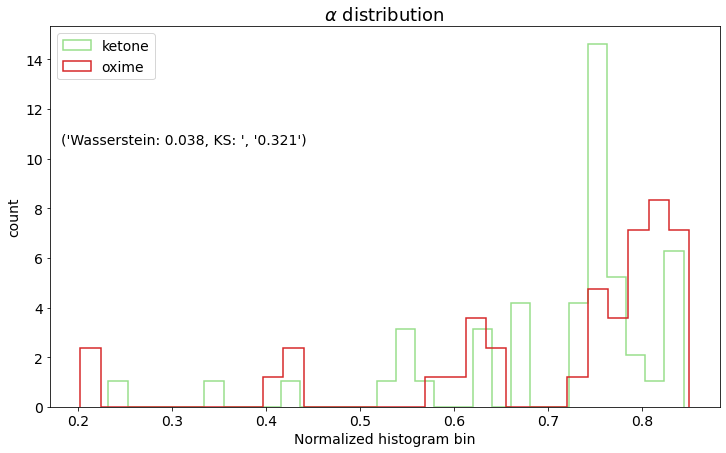

ketone_primary alcohol_alphas.png
ketone_primary alcohol_alphas.png


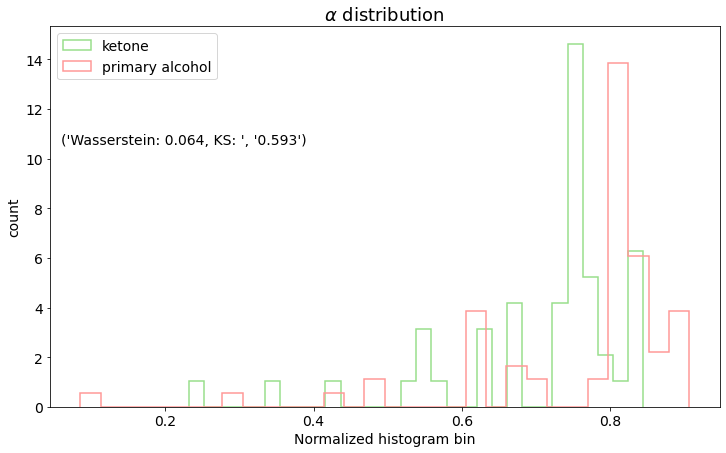

ketone_primary aliphatic amine (alkylamine)_alphas.png
ketone_primary aliphatic amine (alkylamine)_alphas.png


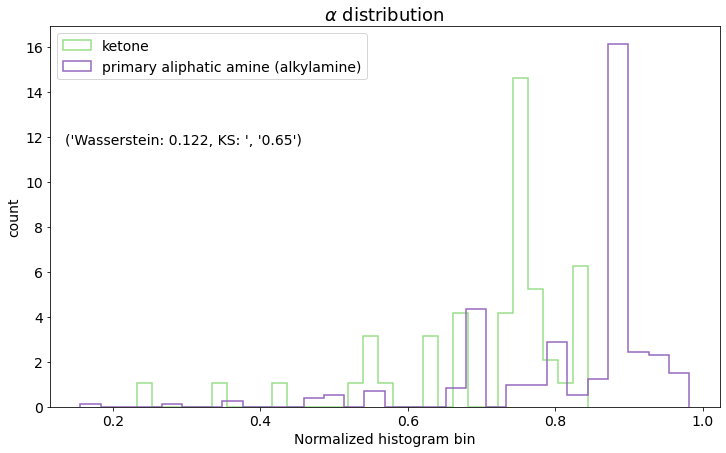

ketone_secondary alcohol_alphas.png
ketone_secondary alcohol_alphas.png


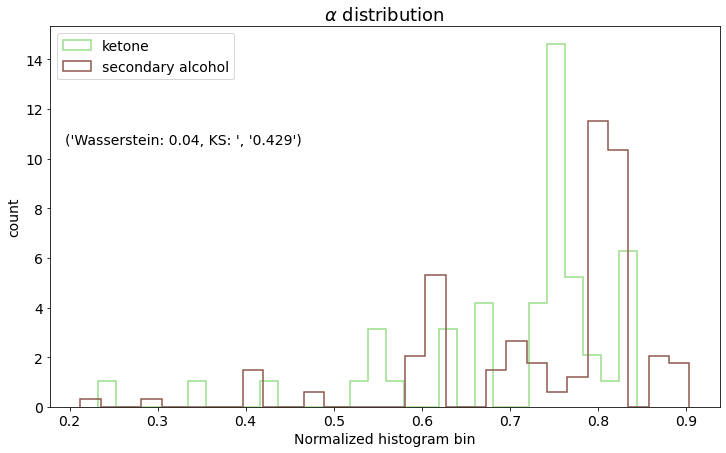

ketone_secondary aliphatic amine (dialkylamine)_alphas.png
ketone_secondary aliphatic amine (dialkylamine)_alphas.png


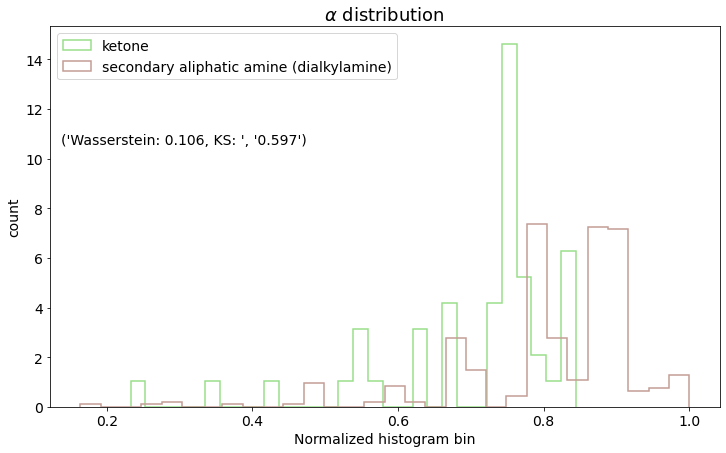

oxime_primary alcohol_alphas.png
oxime_primary alcohol_alphas.png


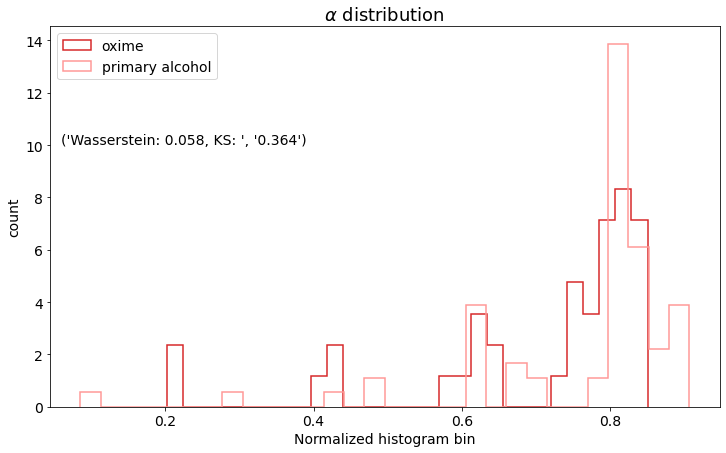

oxime_primary aliphatic amine (alkylamine)_alphas.png
oxime_primary aliphatic amine (alkylamine)_alphas.png


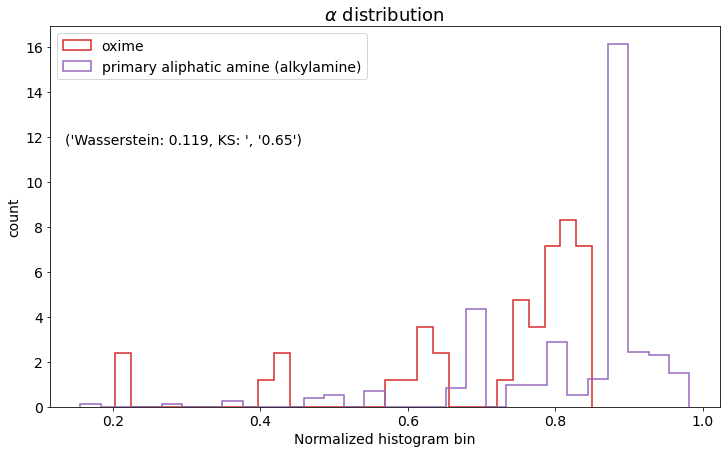

oxime_secondary alcohol_alphas.png
oxime_secondary alcohol_alphas.png


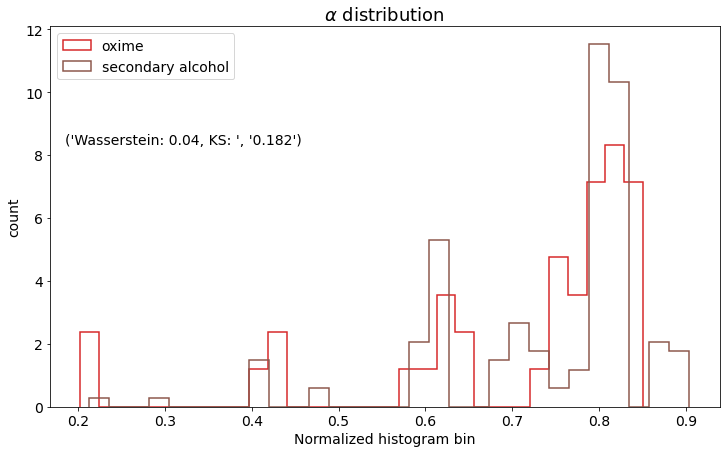

oxime_secondary aliphatic amine (dialkylamine)_alphas.png
oxime_secondary aliphatic amine (dialkylamine)_alphas.png


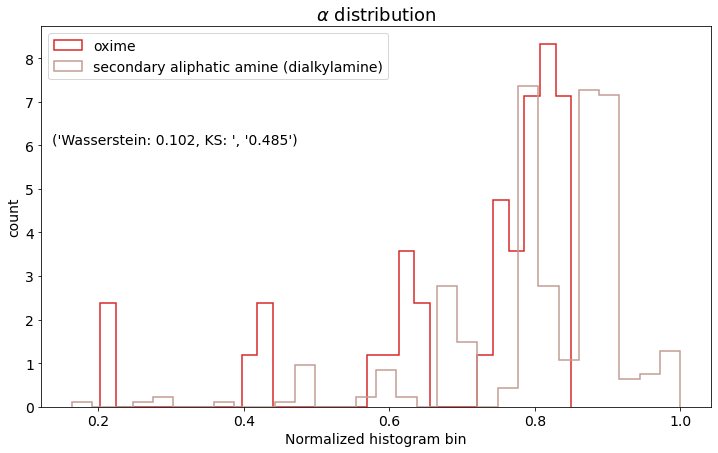

primary alcohol_primary aliphatic amine (alkylamine)_alphas.png
primary alcohol_primary aliphatic amine (alkylamine)_alphas.png


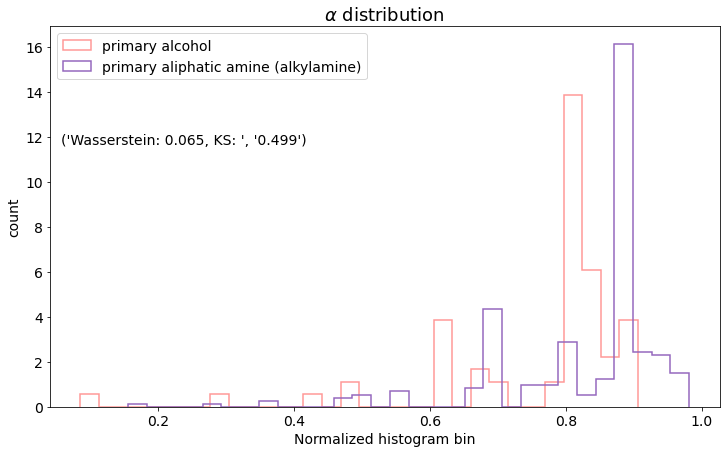

primary alcohol_secondary alcohol_alphas.png
primary alcohol_secondary alcohol_alphas.png


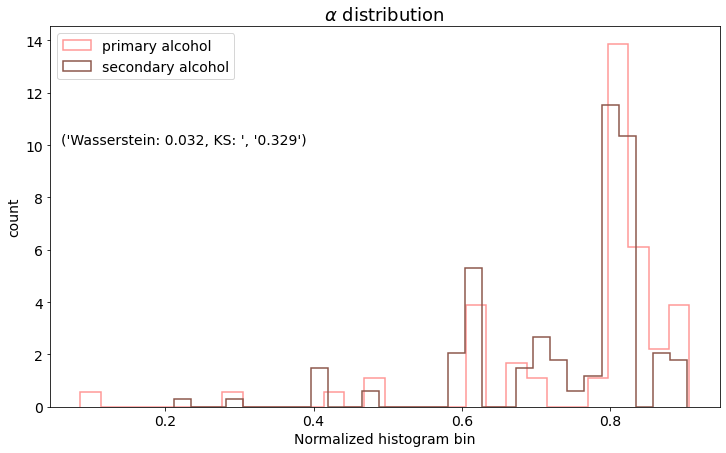

primary alcohol_secondary aliphatic amine (dialkylamine)_alphas.png
primary alcohol_secondary aliphatic amine (dialkylamine)_alphas.png


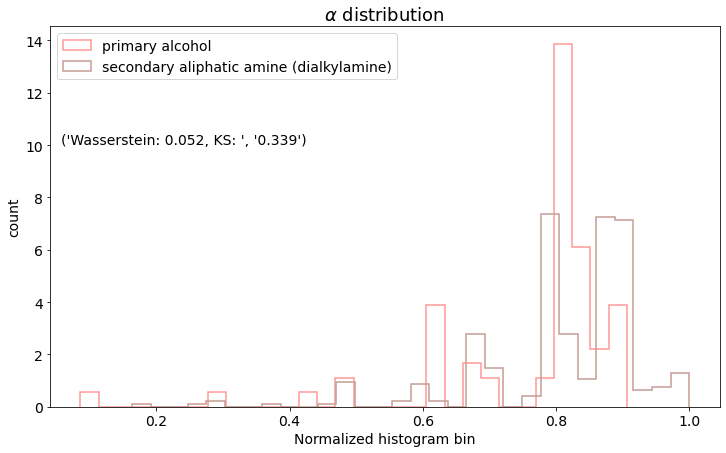

primary aliphatic amine (alkylamine)_secondary alcohol_alphas.png
primary aliphatic amine (alkylamine)_secondary alcohol_alphas.png


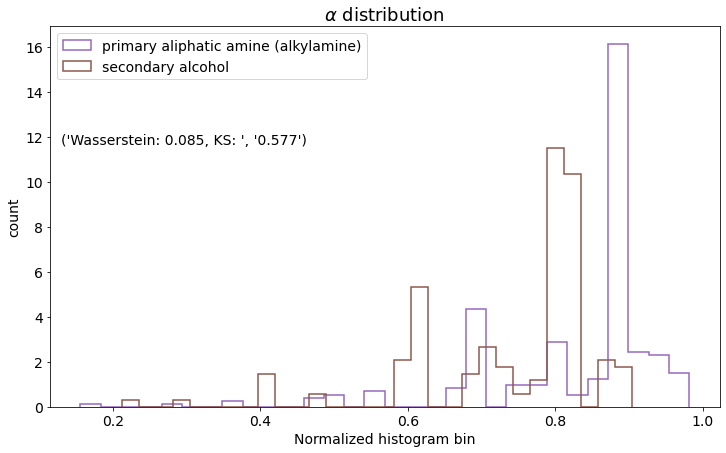

primary aliphatic amine (alkylamine)_secondary aliphatic amine (dialkylamine)_alphas.png
primary aliphatic amine (alkylamine)_secondary aliphatic amine (dialkylamine)_alphas.png


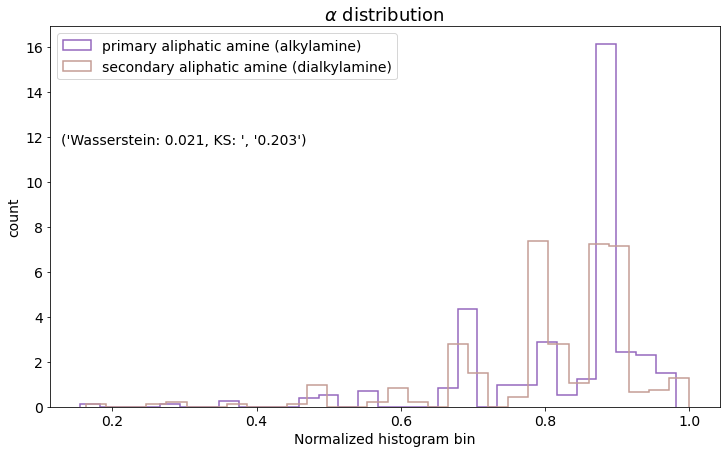

secondary alcohol_secondary aliphatic amine (dialkylamine)_alphas.png
secondary alcohol_secondary aliphatic amine (dialkylamine)_alphas.png


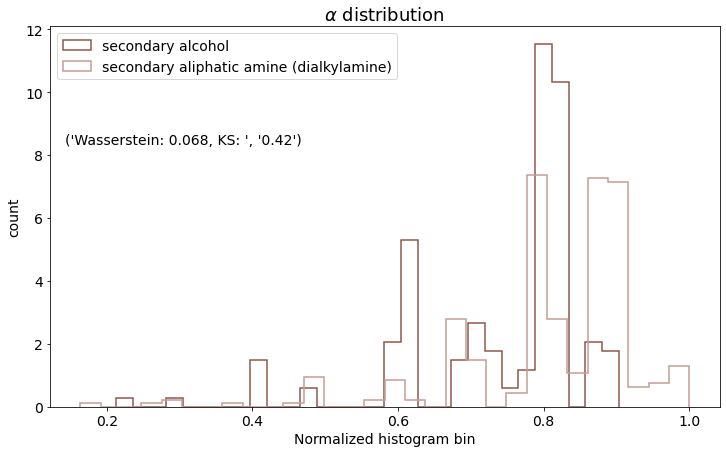

In [29]:
# Creating histograms along the ALPHA
list_of_hists = []

flat_pruned_alphas = [point["dft_alpha_avg"] for point in single_groups]


alpha_pair_wasserstein,alpha_pair_ks  = [],[]


# Generating all possible pairs
for pair in itertools.combinations(range(len(chosen_groups)),2):
    # normalizing the data
    norm1 = np.asarray( (alphas_fcngroup[pair[0]] - np.min(flat_pruned_alphas))/(np.max(flat_pruned_alphas)-np.min(flat_pruned_alphas)))
    norm2 = np.asarray( (alphas_fcngroup[pair[1]] - np.min(flat_pruned_alphas))/(np.max(flat_pruned_alphas)-np.min(flat_pruned_alphas)))
   
    hist1 = plt.hist(norm1,bins=30,histtype='step',color=colors[pair[0]], density=True,  linewidth=1.5, label=chosen_groups[pair[0]])
    hist2 = plt.hist(norm2,bins=30,histtype='step',color=colors[pair[1]], density=True,  linewidth=1.5, label=chosen_groups[pair[1]])
    
    plt.legend(loc="upper left",fontsize=14)
    plt.xlabel(r"Normalized histogram bin",fontsize=14)
    plt.ylabel(r"count",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(r"$\alpha$ distribution",fontsize=18)
    plotname_string=chosen_groups[pair[0]]+"_"+chosen_groups[pair[1]]+"_alphas.png"
 #   plt.savefig(plotname_string)
    print(plotname_string)
    
    #adding some statistical numbers right onto the plot
    string="Wasserstein: "+str(round(wasserstein_distance(norm1,norm2),3)) +", KS: ", str(round(stats.ks_2samp(norm1,norm2)[0],3))
    plt.text(0.2,0.7, string,  horizontalalignment='center', verticalalignment='center',size='14', transform=plt.gca().transAxes)
    plotname_string=chosen_groups[pair[0]]+"_"+chosen_groups[pair[1]]+"_alphas.png"
    #plt.savefig(plotname_string)
    print(plotname_string)
    plt.show()
    alpha_pair_wasserstein.append(wasserstein_distance(norm1,norm2))
    alpha_pair_ks.append(stats.ks_2samp(norm1,norm2)[0])


In [30]:
# Checking the statistics on the distances

print("Average HL distance between functional groups: ",np.average(hlgap_pair_ks))
print("Average alpha distance between functional groups: ",np.average(alpha_pair_ks))


Average HL distance between functional groups:  0.8092361010244483
Average alpha distance between functional groups:  0.3961871871314283
